In [2]:
import os
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 500)

In [3]:
path_datasets = 'input/'

df_rs_d_res = pd.read_csv(path_datasets + 'RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(path_datasets + 'Teams.csv')
df_seeds = pd.read_csv(path_datasets + 'NCAATourneySeeds.csv')
coaches = pd.read_csv(path_datasets + 'TeamCoaches.csv')
df_tourn = pd.read_csv(path_datasets + 'NCAATourneyCompactResults.csv')

# Data prep

In [4]:
# clean team and seed information

df_teams_cl = df_teams[['TeamID', 'TeamName']]

df_seeds_cl = df_seeds.copy()

df_seeds_cl['seed_int'] = df_seeds_cl['Seed'].str[1:3].astype(int)
df_seeds_cl['seed_region'] = df_seeds_cl['Seed'].str[0:1]
df_seeds_cl['top_seeded_teams'] = np.where(df_seeds_cl['Seed'].isnull(), 0, 1)

df_seeds_cl.drop(columns=['Seed'], inplace=True)
df_seeds_cl.head()

,Season,TeamID,seed_int,seed_region,top_seeded_teams
0,1985,1207,1,W,1
1,1985,1210,2,W,1
2,1985,1228,3,W,1
3,1985,1260,4,W,1
4,1985,1374,5,W,1


In [5]:
df_rs_d_res.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


## Team stats

In [6]:
# Create dataframe showing stats (including opposing team stats) for all winners

temp_df = df_rs_d_res.copy()

temp_df['poss']         = temp_df['WFGA']+0.475*temp_df['WFTA']-temp_df['WOR']+temp_df['WTO']
temp_df['opp_poss']     = temp_df['LFGA']+0.475*temp_df['LFTA']-temp_df['LOR']+temp_df['LTO']
temp_df['off_rating']   = 100*(temp_df['WScore']/temp_df['poss'])
temp_df['def_rating']   = 100*(temp_df['LScore']/temp_df['opp_poss'])
temp_df['net_rating']   = temp_df['off_rating']-temp_df['def_rating']
temp_df['3PAr']         = temp_df['WFGA3']/temp_df['WFGA']
temp_df['pace']         = 48*((temp_df['poss']+temp_df['opp_poss'])/(2*(240/5)))
temp_df['efg']          = (temp_df['WFGM']+(temp_df['WFGM3']*0.5))/temp_df['WFGA']
temp_df['efg_opp']      = (temp_df['LFGM'] + (temp_df['LFGM3']*0.5))/temp_df['LFGA']
temp_df['tov']          = temp_df['WTO']/((temp_df['WFGA'] + 0.44)+(temp_df['WFTA']+temp_df['WTO']))
temp_df['orb']          = temp_df['WOR']/(temp_df['WOR']+temp_df['LDR'])
temp_df['drb']          = temp_df['WDR']/(temp_df['WDR']+temp_df['LOR'])
temp_df['ftar']         = temp_df['WFTA']/(temp_df['WFGA'])
temp_df['ftar_opp']     = temp_df['LFTA']/(temp_df['LFGA'])
temp_df['ts']           = temp_df['WScore']/((temp_df['WFGA']*2)+(0.88*temp_df['WFTA']))
temp_df['ts_opp']       =  temp_df['LScore']/((temp_df['LFGA']*2)+(0.88*temp_df['LFTA']))
temp_df['astto']        = (temp_df['WAst']/(temp_df['WTO']))
temp_df['astto_opp']    = (temp_df['LAst']/(temp_df['LTO']))
temp_df['astr']         = ((temp_df['WAst']*100)\
                            /((temp_df['WFGA']+(temp_df['WFTA']*0.44))+temp_df['WAst']+temp_df['WTO']))
temp_df['astr_opp']     = ((temp_df['LAst']*100)\
                           /((temp_df['LFGA']+(temp_df['LFTA']*0.44))+temp_df['LAst']+temp_df['LTO']))
temp_df['tr']           = temp_df['WOR']+temp_df['WDR']
temp_df['tr_opp']       = temp_df['LOR']+temp_df['LDR']
temp_df['rebp']         = (100*(temp_df['WDR']+temp_df['WOR'])\
                           /(temp_df['WDR']+temp_df['WOR']+temp_df['LDR']+temp_df['LOR']))
temp_df['off3']         = (temp_df['WFGM3']/(temp_df['WFGA3']))
temp_df['def3']         = (temp_df['LFGM3']/(temp_df['LFGA3']))
temp_df['tov_opp']      = temp_df['LTO']/((temp_df['LFGA']+0.44)+(temp_df['LFTA']+temp_df['LTO']))
temp_df['tor']          = ((temp_df['WTO']*100)\
                           /(temp_df['WFGA']+(temp_df['WFTA']*0.44)+temp_df['WAst']+temp_df['WTO']))
temp_df['tor_opp']      = (temp_df['LTO']*100)/(temp_df['LFGA']+(temp_df['LFTA']*0.44)+temp_df['LAst']+temp_df['LTO'])
temp_df['stlto']        = temp_df['WStl']/temp_df['WTO']
temp_df['stlto_opp']    = temp_df['LStl']/temp_df['LTO']
temp_df['pie']          = ((temp_df['WScore']+temp_df['WFGM']+temp_df['WFTM']-temp_df['WFGA']-temp_df['WFTA']\
                            +temp_df['WDR']+(0.5*temp_df['WOR'])+temp_df['WAst']+temp_df['WStl']\
                            +(0.5*temp_df['WBlk'])-temp_df['WPF']-temp_df['WTO'])\
                           /((temp_df['WScore']+temp_df['WFGM']+temp_df['WFTM']-temp_df['WFGA']-temp_df['WFTA']\
                            +temp_df['WDR']+(0.5*temp_df['WOR'])+temp_df['WAst']+temp_df['WStl']\
                            +(0.5*temp_df['WBlk'])-temp_df['WPF']-temp_df['WTO'])+(temp_df['LScore']+temp_df['LFGM']\
                            +temp_df['LFTM']-temp_df['LFGA']-temp_df['LFTA']+temp_df['LDR']+(0.5*temp_df['LOR'])\
                            +temp_df['LAst']+temp_df['LStl']+(0.5*temp_df['LBlk'])-temp_df['LPF']-temp_df['LTO'])))


# Rename columns to no suffix for team on left (winning team) and _opp suffix for team on right (losing team)
temp_df.rename(columns={'WTeamID':'TeamID', 
                          'WLoc':'_Loc',
                          'LTeamID':'TeamID_opp',
                          'WScore':'Score_left', 
                          'LScore':'Score_right'}, inplace=True)

df_seeds_opp = df_seeds_cl.rename(columns={'TeamID':'TeamID_opp',
                              'seed_int':'seed_int_opp',
                              'seed_region':'seed_region_opp',
                              'top_seeded_teams':'top_seeded_teams_opp'})

# Merge to add team seeds                           
df_winners = pd.merge(left=temp_df, right=df_seeds_cl, how='left', on=['Season', 'TeamID'])
df_winners = pd.merge(left=df_winners, right=df_seeds_opp, how='left', on=['Season', 'TeamID_opp'])
df_winners = pd.merge(left=df_winners, right=df_teams_cl, how='left', on=['TeamID'])

df_winners['DayNum'] = pd.to_numeric(df_winners['DayNum'])
df_winners['win_dummy'] = 1

# Fill nulls of unseeded and no regions team
df_winners['seed_int'] = df_winners['seed_int']
df_winners['seed_region'] = df_winners['seed_region'].fillna('NoTour')
df_winners['top_seeded_teams'] = df_winners['top_seeded_teams'].fillna(0)

df_winners['seed_int_opp'] = df_winners['seed_int_opp']
df_winners['seed_region_opp'] = df_winners['seed_region_opp'].fillna('NoTour')
df_winners['top_seeded_teams_opp'] = df_winners['top_seeded_teams_opp'].fillna(0)
                           
# Rename rest of columns to no suffix and _opp suffix
def new_name_w_1(old_name):
    match = re.match(r'^L', old_name)
    if match:
        out = re.sub('^L','', old_name)
        return out + '_opp'
    return old_name

def new_name_w_2(old_name):
    match = re.match(r'^W', old_name)
    if match:
        out = re.sub('^W','', old_name)
        return out
    return old_name                           
                           
df_winners = df_winners.rename(columns=new_name_w_1)
df_winners = df_winners.rename(columns=new_name_w_2)
                           
df_winners.head()

,Season,DayNum,TeamID,Score_left,TeamID_opp,Score_right,_Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGM_opp,FGA_opp,FGM3_opp,FGA3_opp,FTM_opp,FTA_opp,OR_opp,DR_opp,Ast_opp,TO_opp,Stl_opp,Blk_opp,PF_opp,poss,opp_poss,off_rating,def_rating,net_rating,3PAr,pace,efg,efg_opp,tov,orb,drb,ftar,ftar_opp,ts,ts_opp,astto,astto_opp,astr,astr_opp,tr,tr_opp,rebp,off3,def3,tov_opp,tor,tor_opp,stlto,stlto_opp,pie,seed_int,seed_region,top_seeded_teams,seed_int_opp,seed_region_opp,top_seeded_teams_opp,TeamName,win_dummy
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,75.550,71.450,90.006618,86.773968,3.232650,0.241379,73.5000,0.491379,0.433962,0.231295,0.388889,0.705882,0.310345,0.415094,0.515777,0.494576,0.565217,0.444444,12.755102,9.021200,38,32,54.285714,0.214286,0.200000,0.192637,22.566719,20.297700,0.304348,0.500000,0.532847,10.0,Y,1.0,1.0,W,1.0,Alabama,1
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,69.025,68.500,101.412532,91.970803,9.441729,0.322581,68.7625,0.483871,0.402985,0.137654,0.375000,0.583333,0.306452,0.298507,0.497442,0.415567,1.230769,0.583333,16.103060,7.383966,43,45,48.863636,0.400000,0.250000,0.120676,13.083736,12.658228,0.307692,0.666667,0.602339,7.0,Z,1.0,3.0,W,1.0,Memphis,1
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,64.775,64.925,112.697800,93.954563,18.743237,0.310345,64.8500,0.482759,0.321918,0.102627,0.435897,0.456140,0.500000,0.315068,0.515828,0.366939,1.500000,0.750000,15.664160,8.643872,43,53,44.791667,0.444444,0.115385,0.110660,10.442774,11.525163,0.500000,0.166667,0.736434,3.0,Y,1.0,NaN,NoTour,0.0,Marquette,1
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,58.725,58.125,95.359728,86.021505,9.338222,0.236842,58.4250,0.513158,0.428571,0.147348,0.230769,0.527778,0.815789,0.306122,0.542215,0.449640,0.916667,0.473684,14.737406,10.765550,25,37,40.322581,0.333333,0.272727,0.227709,16.077170,22.727273,1.166667,0.210526,0.754717,NaN,NoTour,0.0,NaN,NoTour,0.0,N Illinois,1
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,64.175,63.825,119.984418,111.241676,8.742741,0.229508,64.0000,0.540984,0.435484,0.158299,0.531250,0.511628,0.213115,0.435484,0.577038,0.480509,0.857143,1.200000,12.942192,12.515645,39,36,52.000000,0.428571,0.375000,0.100563,15.099223,10.429704,0.285714,0.700000,0.570732,1.0,X,1.0,NaN,NoTour,0.0,Texas,1


In [7]:
# Same thing as above but for losers

temp_df = df_rs_d_res.copy()

temp_df['poss']         = temp_df['LFGA']+0.475*temp_df['LFTA']-temp_df['LOR']+temp_df['LTO']
temp_df['opp_poss']     = temp_df['WFGA']+0.475*temp_df['WFTA']-temp_df['WOR']+temp_df['WTO']
temp_df['off_rating']   = 100*(temp_df['LScore']/temp_df['poss'])
temp_df['def_rating']   = 100*(temp_df['WScore']/temp_df['opp_poss'])
temp_df['net_rating']   = temp_df['off_rating']-temp_df['def_rating']
temp_df['3PAr']         = temp_df['LFGA3']/temp_df['LFGA']
temp_df['pace']         = 48*((temp_df['poss']+temp_df['opp_poss'])/(2*(240/5)))
temp_df['efg']          = (temp_df['LFGM']+(temp_df['LFGM3']*0.5))/temp_df['LFGA']
temp_df['efg_opp']      = (temp_df['WFGM'] + (temp_df['WFGM3']*0.5))/temp_df['WFGA']
temp_df['tov']          = temp_df['LTO']/((temp_df['LFGA'] + 0.44)+(temp_df['LFTA']+temp_df['LTO']))
temp_df['orb']          = temp_df['LOR']/(temp_df['LOR']+temp_df['WDR'])
temp_df['drb']          = temp_df['LDR']/(temp_df['LDR']+temp_df['WOR'])
temp_df['ftar']         = temp_df['LFTA']/(temp_df['LFGA'])
temp_df['ftar_opp']     = temp_df['WFTA']/(temp_df['WFGA'])
temp_df['ts']           = temp_df['LScore']/((temp_df['LFGA']*2)+(0.88*temp_df['LFTA']))
temp_df['ts_opp']       =  temp_df['WScore']/((temp_df['WFGA']*2)+(0.88*temp_df['WFTA']))
temp_df['astto']        = (temp_df['LAst']/(temp_df['LTO']))
temp_df['astto_opp']    = (temp_df['WAst']/(temp_df['WTO']))
temp_df['astr']         = ((temp_df['LAst']*100)\
                            /((temp_df['LFGA']+(temp_df['LFTA']*0.44))+temp_df['LAst']+temp_df['LTO']))
temp_df['astr_opp']     = ((temp_df['WAst']*100)\
                           /((temp_df['WFGA']+(temp_df['WFTA']*0.44))+temp_df['WAst']+temp_df['WTO']))
temp_df['tr']           = temp_df['LOR']+temp_df['LDR']
temp_df['tr_opp']       = temp_df['WOR']+temp_df['WDR']
temp_df['rebp']         = (100*(temp_df['LDR']+temp_df['LOR'])\
                           /(temp_df['LDR']+temp_df['LOR']+temp_df['WDR']+temp_df['WOR']))
temp_df['off3']         = (temp_df['LFGM3']/(temp_df['LFGA3']))
temp_df['def3']         = (temp_df['WFGM3']/(temp_df['WFGA3']))
temp_df['tov_opp']      = temp_df['WTO']/((temp_df['WFGA']+0.44)+(temp_df['WFTA']+temp_df['WTO']))
temp_df['tor']          = ((temp_df['LTO']*100)\
                           /(temp_df['LFGA']+(temp_df['LFTA']*0.44)+temp_df['LAst']+temp_df['LTO']))
temp_df['tor_opp']      = (temp_df['WTO']*100)/(temp_df['WFGA']+(temp_df['WFTA']*0.44)+temp_df['WAst']+temp_df['WTO'])
temp_df['stlto']        = temp_df['LStl']/temp_df['LTO']
temp_df['stlto_opp']    = temp_df['WStl']/temp_df['WTO']
temp_df['pie']          = ((temp_df['LScore']+temp_df['LFGM']+temp_df['LFTM']-temp_df['LFGA']-temp_df['LFTA']\
                            +temp_df['LDR']+(0.5*temp_df['LOR'])+temp_df['LAst']+temp_df['LStl']\
                            +(0.5*temp_df['LBlk'])-temp_df['LPF']-temp_df['LTO'])\
                           /((temp_df['LScore']+temp_df['LFGM']+temp_df['LFTM']-temp_df['LFGA']-temp_df['LFTA']\
                            +temp_df['LDR']+(0.5*temp_df['LOR'])+temp_df['LAst']+temp_df['LStl']\
                            +(0.5*temp_df['LBlk'])-temp_df['LPF']-temp_df['LTO'])+(temp_df['WScore']+temp_df['WFGM']\
                            +temp_df['WFTM']-temp_df['WFGA']-temp_df['WFTA']+temp_df['WDR']+(0.5*temp_df['WOR'])\
                            +temp_df['WAst']+temp_df['WStl']+(0.5*temp_df['WBlk'])-temp_df['WPF']-temp_df['WTO'])))

# Rename columns to no suffix for team on left (losing team) and _opp suffix for team on right (winning team)
temp_df.rename(columns={'LTeamID':'TeamID', 
                                  'WLoc':'_Loc',
                                  'WTeamID':'TeamID_opp',
                                  'LScore':'Score_left', 
                                  'WScore':'Score_right'}, inplace=True)

# Merge to add team seeds                           
df_losers = pd.merge(left=temp_df, right=df_seeds_cl, how='left', on=['Season', 'TeamID'])
df_losers = pd.merge(left=df_losers, right=df_seeds_opp, how='left', on=['Season', 'TeamID_opp'])
df_losers = pd.merge(left=df_losers, right=df_teams_cl, how='left', on=['TeamID'])

df_losers['DayNum'] = pd.to_numeric(df_losers['DayNum'])
df_losers['win_dummy'] = 0

# Fill nulls of unseeded and no regions team
df_losers['seed_int'] = df_losers['seed_int']
df_losers['seed_region'] = df_losers['seed_region'].fillna('NoTour')
df_losers['top_seeded_teams'] = df_losers['top_seeded_teams'].fillna(0)

df_losers['seed_int_opp'] = df_losers['seed_int_opp']
df_losers['seed_region_opp'] = df_losers['seed_region_opp'].fillna('NoTour')
df_losers['top_seeded_teams_opp'] = df_losers['top_seeded_teams_opp'].fillna(0)
                           
# Rename rest of columns to no suffix and _opp suffix
def new_name_l_1(old_name):
    match = re.match(r'^W', old_name)
    if match:
        out = re.sub('^W','', old_name)
        return out + '_opp'
    return old_name

def new_name_l_2(old_name):
    match = re.match(r'^L', old_name)
    if match:
        out = re.sub('^L','', old_name)
        return out
    return old_name                          
                           
df_losers = df_losers.rename(columns=new_name_w_1)
df_losers = df_losers.rename(columns=new_name_w_2)
                           
df_losers.head()

,Season,DayNum,TeamID_opp,Score_right,TeamID,Score_left,_Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGM_opp,FGA_opp,FGM3_opp,FGA3_opp,FTM_opp,FTA_opp,OR_opp,DR_opp,Ast_opp,TO_opp,Stl_opp,Blk_opp,PF_opp,poss,opp_poss,off_rating,def_rating,net_rating,3PAr,pace,efg,efg_opp,tov,orb,drb,ftar,ftar_opp,ts,ts_opp,astto,astto_opp,astr,astr_opp,tr,tr_opp,rebp,off3,def3,tov_opp,tor,tor_opp,stlto,stlto_opp,pie,seed_int,seed_region,top_seeded_teams,seed_int_opp,seed_region_opp,top_seeded_teams_opp,TeamName,win_dummy
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,71.450,75.550,86.773968,90.006618,-3.232650,0.188679,73.5000,0.433962,0.491379,0.192637,0.294118,0.611111,0.415094,0.310345,0.494576,0.515777,0.444444,0.565217,9.021200,12.755102,32,38,45.714286,0.200000,0.214286,0.231295,20.297700,22.566719,0.500000,0.304348,0.467153,1.0,W,1.0,10.0,Y,1.0,Oklahoma,0
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,68.500,69.025,91.970803,101.412532,-9.441729,0.358209,68.7625,0.402985,0.483871,0.120676,0.416667,0.625000,0.298507,0.306452,0.415567,0.497442,0.583333,1.230769,7.383966,16.103060,45,43,51.136364,0.250000,0.400000,0.137654,12.658228,13.083736,0.666667,0.307692,0.397661,3.0,W,1.0,7.0,Z,1.0,Syracuse,0
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,64.925,64.775,93.954563,112.697800,-18.743237,0.356164,64.8500,0.321918,0.482759,0.110660,0.543860,0.564103,0.315068,0.500000,0.366939,0.515828,0.750000,1.500000,8.643872,15.664160,53,43,55.208333,0.115385,0.444444,0.102627,11.525163,10.442774,0.166667,0.500000,0.263566,NaN,NoTour,0.0,3.0,Y,1.0,Villanova,0
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,58.125,58.725,86.021505,95.359728,-9.338222,0.448980,58.4250,0.428571,0.513158,0.227709,0.472222,0.769231,0.306122,0.815789,0.449640,0.542215,0.473684,0.916667,10.765550,14.737406,37,25,59.677419,0.272727,0.333333,0.147348,22.727273,16.077170,0.210526,1.166667,0.245283,NaN,NoTour,0.0,NaN,NoTour,0.0,Winthrop,0
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,63.825,64.175,111.241676,119.984418,-8.742741,0.258065,64.0000,0.435484,0.540984,0.100563,0.488372,0.468750,0.435484,0.213115,0.480509,0.577038,1.200000,0.857143,12.515645,12.942192,36,39,48.000000,0.375000,0.428571,0.158299,10.429704,15.099223,0.700000,0.285714,0.429268,NaN,NoTour,0.0,1.0,X,1.0,Georgia,0


In [8]:
# Concatenate both dataframes to get stats for every team

df_games = pd.concat([df_winners, df_losers], sort=False)

# Aggregate stats by teams and by season

def aggr_stats(df):
    d = {}
    d['G'] = df['win_dummy'].count()
    d['W'] = df['win_dummy'].sum()
    d['L'] = np.sum(df['win_dummy'] == 0)
    d['G_vs_topseeds'] = np.sum(df['top_seeded_teams_opp'] == 1)
    d['W_vs_topseeds'] = np.sum((df['win_dummy'] == 1) & (df['top_seeded_teams_opp'] == 1))
    d['L_vs_topseeds'] = np.sum((df['win_dummy'] == 0) & (df['top_seeded_teams_opp'] == 1))
    d['G_last30D'] = np.sum((df['DayNum'] > 100))
    d['W_last30D'] = np.sum((df['win_dummy'] == 1) & (df['DayNum'] > 100))
    d['L_last30D'] = np.sum((df['win_dummy'] == 0) & (df['DayNum'] > 100))
    d['G_H'] = np.sum((df['_Loc'] == 'H'))
    d['W_H'] = np.sum((df['win_dummy'] == 1) & (df['_Loc'] == 'H'))
    d['L_H'] = np.sum((df['win_dummy'] == 0) & (df['_Loc'] == 'H'))
    d['G_A'] = np.sum((df['_Loc'] == 'A'))
    d['W_A'] = np.sum((df['win_dummy'] == 1) & (df['_Loc'] == 'A'))
    d['L_A'] = np.sum((df['win_dummy'] == 0) & (df['_Loc'] == 'A'))
    d['G_N'] = np.sum((df['_Loc'] == 'N'))
    d['W_N'] = np.sum((df['win_dummy'] == 1) & (df['_Loc'] == 'N'))
    d['L_N'] = np.sum((df['win_dummy'] == 0) & (df['_Loc'] == 'N'))
    
    d['PS'] = np.mean(df['Score_left'])
    d['PS_H'] = np.mean(df['Score_left'][df['_Loc'] == 'H'])
    d['PS_A'] = np.mean(df['Score_left'][df['_Loc'] == 'A'])
    d['PS_N'] = np.mean(df['Score_left'][df['_Loc'] == 'N'])
    d['PS_last30D'] = np.mean(df['Score_left'][df['DayNum'] > 100])
    
    d['PA'] = np.mean(df['Score_right'])
    d['PA_H'] = np.mean(df['Score_right'][df['_Loc'] == 'H'])
    d['PA_A'] = np.mean(df['Score_right'][df['_Loc'] == 'A'])
    d['PA_N'] = np.mean(df['Score_right'][df['_Loc'] == 'N'])
    d['PA_last30D'] = np.mean(df['Score_right'][df['DayNum'] > 100])
    
    d['poss_m'] = np.mean(df['poss'])
    d['opp_poss_m'] = np.mean(df['opp_poss'])
    d['off_rating_m'] = np.mean(df['off_rating'])
    d['def_rating_m'] = np.mean(df['def_rating'])
    d['net_rating_m'] = np.mean(df['net_rating'])
    d['pace_m'] = np.mean(df['pace'])
    d['3PAr'] = np.mean(df['3PAr'])
    d['efg'] = np.mean(df['efg'])
    d['efg_opp'] = np.mean(df['efg_opp'])
    d['tov'] = np.mean(df['tov'])
    d['tov_opp'] = np.mean(df['tov_opp'])
    d['orb'] = np.mean(df['orb'])
    d['drb'] = np.mean(df['drb'])
    d['ftar'] = np.mean(df['ftar'])
    d['ftar_opp'] = np.mean(df['ftar_opp'])
    d['ts'] = np.mean(df['ts'])
    d['ts_opp'] = np.mean(df['ts_opp'])
    d['astto'] = np.mean(df['astto'])
    d['astto_opp'] = np.mean(df['astto_opp'])
    d['astr'] = np.mean(df['astr'])
    d['astr_opp'] = np.mean(df['astr_opp'])
    d['tr'] = np.mean(df['tr'])
    d['tr_opp'] = np.mean(df['tr_opp'])
    d['rebp'] = np.mean(df['rebp'])
    d['off3'] = np.mean(df['off3'])
    d['def3'] = np.mean(df['def3'])
    d['tor'] = np.mean(df['tor'])
    d['stlto'] = np.mean(df['stlto'])
    d['stlto_opp'] = np.mean(df['stlto_opp'])
    d['pie'] = np.mean(df['pie'])
    d['tor_opp'] = np.mean(df['tor_opp'])

    
    d['off_rating_m_last30D'] = np.mean(df['off_rating'][df['DayNum'] > 100])
    d['def_rating_m_last30D'] = np.mean(df['def_rating'][df['DayNum'] > 100])
    d['net_rating_m_last30D'] = np.mean(df['net_rating'][df['DayNum'] > 100])
    
    d['off_rating_m_vs_topseeds'] = np.mean(df['off_rating'][df['top_seeded_teams_opp'] == 1])
    d['def_rating_m_vs_topseeds'] = np.mean(df['def_rating'][df['top_seeded_teams_opp'] == 1])
    d['net_rating_m_vs_topseeds'] = np.mean(df['net_rating'][df['top_seeded_teams_opp'] == 1])
    
    return pd.Series(d)


df_agg_stats = df_games.groupby(['Season', 
                                 'TeamID',
                                 'TeamName',
                                 'seed_int',
                                 'seed_region']).apply(aggr_stats).reset_index()


df_agg_stats['w_pct'] = df_agg_stats['W'] / df_agg_stats['G']
df_agg_stats['w_pct_last30D'] = df_agg_stats['W_last30D'] / df_agg_stats['G_last30D']
df_agg_stats['w_pct_vs_topseeds'] = df_agg_stats['W_vs_topseeds'] / df_agg_stats['G_vs_topseeds']

# Some teams have no games against top seeded teams, so vs_topseeds colums are null
df_agg_stats = df_agg_stats.fillna(0)

df_agg_stats.head()

,Season,TeamID,TeamName,seed_int,seed_region,G,W,L,G_vs_topseeds,W_vs_topseeds,L_vs_topseeds,G_last30D,W_last30D,L_last30D,G_H,W_H,L_H,G_A,W_A,L_A,G_N,W_N,L_N,PS,PS_H,PS_A,PS_N,PS_last30D,PA,PA_H,PA_A,PA_N,PA_last30D,poss_m,opp_poss_m,off_rating_m,def_rating_m,net_rating_m,pace_m,3PAr,efg,efg_opp,tov,tov_opp,orb,drb,ftar,ftar_opp,ts,ts_opp,astto,astto_opp,astr,astr_opp,tr,tr_opp,rebp,off3,def3,tor,stlto,stlto_opp,pie,tor_opp,off_rating_m_last30D,def_rating_m_last30D,net_rating_m_last30D,off_rating_m_vs_topseeds,def_rating_m_vs_topseeds,net_rating_m_vs_topseeds,w_pct,w_pct_last30D,w_pct_vs_topseeds
0,2003,1104,Alabama,10.0,Y,28.0,17.0,11.0,11.0,5.0,6.0,8.0,4.0,4.0,21.0,13.0,8.0,3.0,1.0,2.0,4.0,3.0,1.0,69.285714,70.761905,63.666667,65.750000,72.875000,65.000000,64.619048,69.333333,63.750000,67.750000,66.833929,66.607143,103.369974,98.055068,5.314906,66.720536,0.346570,0.475785,0.480099,0.145579,0.159553,0.371256,0.686897,0.372350,0.315141,0.521729,0.518348,0.992390,0.947733,13.098331,13.151323,37.500000,33.535714,52.649037,0.325442,0.330969,14.573740,0.525862,0.437459,0.536514,15.654694,108.858455,103.367799,5.490656,95.831973,98.942661,-3.110688,0.607143,0.500000,0.454545
1,2003,1112,Arizona,1.0,Z,28.0,25.0,3.0,12.0,10.0,2.0,8.0,7.0,1.0,15.0,14.0,1.0,12.0,11.0,1.0,1.0,0.0,1.0,85.214286,86.400000,83.416667,89.000000,86.625000,70.250000,67.333333,71.750000,96.000000,72.625000,77.196429,76.842857,110.623626,91.782211,18.841415,77.019643,0.304801,0.517632,0.457036,0.139118,0.169140,0.394027,0.680560,0.387965,0.278942,0.557334,0.485062,1.293499,1.024730,16.071897,14.694732,42.821429,36.392857,54.145064,0.351060,0.312230,13.485207,0.613617,0.385089,0.654693,16.067021,114.078080,95.884574,18.193506,112.715440,98.524430,14.191009,0.892857,0.875000,0.833333
2,2003,1113,Arizona St,10.0,Z,29.0,18.0,11.0,14.0,4.0,10.0,8.0,4.0,4.0,18.0,12.0,6.0,7.0,4.0,3.0,4.0,2.0,2.0,75.965517,78.111111,71.000000,75.000000,82.625000,69.172414,69.611111,65.142857,74.250000,78.875000,69.655172,69.918103,109.231055,98.751442,10.479613,69.786638,0.221225,0.517334,0.496914,0.144109,0.169618,0.398080,0.683950,0.468561,0.376157,0.557354,0.535507,1.203251,0.968886,15.835780,14.804880,37.000000,31.551724,53.909832,0.328376,0.341896,14.340035,0.395731,0.393606,0.585160,16.621370,113.723998,109.611806,4.112192,102.061499,108.027551,-5.966052,0.620690,0.500000,0.285714
3,2003,1120,Auburn,10.0,W,30.0,19.0,11.0,12.0,4.0,8.0,9.0,3.0,6.0,18.0,13.0,5.0,7.0,3.0,4.0,5.0,3.0,2.0,70.100000,73.666667,60.857143,70.200000,62.777778,65.566667,65.722222,62.857143,68.800000,71.222222,68.040000,68.053333,102.641556,96.595411,6.046145,68.046667,0.296319,0.521096,0.484555,0.176435,0.177883,0.369907,0.647626,0.366599,0.295281,0.552236,0.515074,0.938475,0.875115,14.182114,13.651171,34.500000,32.833333,51.000456,0.355662,0.337164,17.298465,0.556822,0.546057,0.586442,17.171566,94.828290,107.558509,-12.730219,96.414120,106.959201,-10.545080,0.633333,0.333333,0.333333
4,2003,1122,Austin Peay,13.0,W,27.0,20.0,7.0,2.0,1.0,1.0,9.0,8.0,1.0,18.0,11.0,7.0,6.0,6.0,0.0,3.0,3.0,0.0,69.703704,68.833333,74.000000,66.333333,69.666667,67.703704,69.666667,65.333333,60.666667,63.000000,68.066667,67.977778,102.619586,99.424414,3.195172,68.022222,0.326557,0.513721,0.486276,0.166440,0.155659,0.322149,0.675934,0.478486,0.330714,0.558591,0.521011,0.994424,1.032100,14.601374,14.357562,34.851852,34.185185,50.661714,0.353542,0.367006,16.766428,0.493416,0.505961,0.539992,15.133653,106.182883,95.196608,10.986275,83.718128,107.983764,-24.265636,0.740741,0.888889,0.500000


In [120]:
season_player_stats_df.head()

,Season,PlayerID,TeamID,2PA,2PM,3PA,3PM,AST,BLK,DRB,FTA,FTM,G,ORB,PF,STL,TOV,PTS,team_AST,team_FG,PER,PlayerName
0,2010,600001,1102,16,12,8,2,7,0,11,9,4,16,6,21,7,6,34,356,580,27.095400,BOHANNON_ZACH
1,2010,600002,1102,0,0,0,0,0,0,0,0,0,4,1,2,0,0,0,356,580,0.162835,BRAKEVILLE_ADAM
2,2010,600003,1102,43,20,24,1,11,9,41,39,25,23,13,30,4,22,68,356,580,28.517423,BROEKHUIS_TAYLOR
3,2010,600004,1102,39,23,24,10,6,6,15,19,15,22,10,34,6,11,91,356,580,59.983442,BROOKS_DEREK
4,2010,600005,1102,3,1,1,0,1,0,3,3,1,5,1,1,0,0,3,356,580,1.679780,EL-AMIN_SAJ


In [121]:
# Get team PER by adding all player's PER
# Player game stats only available from 2010 season

team_PER = season_player_stats_df.groupby(['Season','TeamID']).\
                                  agg({'PER': sum}).add_prefix('team_').reset_index()

team_PER.head()

,Season,TeamID,team_PER
0,2010,1102,997.349396
1,2010,1103,1677.462037
2,2010,1104,1677.322853
3,2010,1105,939.943452
4,2010,1106,1177.334888


In [282]:
df_agg_stats_with_PER = pd.merge(df_agg_stats, team_PER, on=['Season', 'TeamID'], how='left')
df_agg_stats_with_PER.head()

,Season,TeamID,TeamName,seed_int,seed_region,G,W,L,G_vs_topseeds,W_vs_topseeds,L_vs_topseeds,G_last30D,W_last30D,L_last30D,G_H,W_H,L_H,G_A,W_A,L_A,G_N,W_N,L_N,PS,PS_H,PS_A,PS_N,PS_last30D,PA,PA_H,PA_A,PA_N,PA_last30D,poss_m,opp_poss_m,off_rating_m,def_rating_m,net_rating_m,pace_m,3PAr,efg,efg_opp,tov,tov_opp,orb,drb,ftar,ftar_opp,ts,ts_opp,astto,astto_opp,astr,astr_opp,tr,tr_opp,rebp,off3,def3,tor,stlto,stlto_opp,pie,tor_opp,off_rating_m_last30D,def_rating_m_last30D,net_rating_m_last30D,off_rating_m_vs_topseeds,def_rating_m_vs_topseeds,net_rating_m_vs_topseeds,w_pct,w_pct_last30D,w_pct_vs_topseeds,team_PER
0,2003,1104,Alabama,10.0,Y,28.0,17.0,11.0,11.0,5.0,6.0,8.0,4.0,4.0,21.0,13.0,8.0,3.0,1.0,2.0,4.0,3.0,1.0,69.285714,70.761905,63.666667,65.750000,72.875000,65.000000,64.619048,69.333333,63.750000,67.750000,66.833929,66.607143,103.369974,98.055068,5.314906,66.720536,0.346570,0.475785,0.434752,0.145579,0.165343,0.371256,0.686897,0.372350,0.303517,0.521729,0.479165,0.992390,0.739935,13.098331,11.401939,37.500000,33.964286,52.649037,0.325442,0.330969,14.573740,0.525862,0.376735,0.536514,16.448720,108.858455,103.367799,5.490656,95.831973,98.942661,-3.110688,0.607143,0.500000,0.454545,NaN
1,2003,1112,Arizona,1.0,Z,28.0,25.0,3.0,12.0,10.0,2.0,8.0,7.0,1.0,15.0,14.0,1.0,12.0,11.0,1.0,1.0,0.0,1.0,85.214286,86.400000,83.416667,89.000000,86.625000,70.250000,67.333333,71.750000,96.000000,72.625000,77.196429,76.842857,110.623626,91.782211,18.841415,77.019643,0.304801,0.517632,0.449988,0.139118,0.165562,0.394027,0.680560,0.387965,0.272112,0.557334,0.476307,1.293499,1.008807,16.071897,14.221434,42.821429,36.178571,54.145064,0.351060,0.312230,13.485207,0.613617,0.412886,0.654693,15.760701,114.078080,95.884574,18.193506,112.715440,98.524430,14.191009,0.892857,0.875000,0.833333,NaN
2,2003,1113,Arizona St,10.0,Z,29.0,18.0,11.0,14.0,4.0,10.0,8.0,4.0,4.0,18.0,12.0,6.0,7.0,4.0,3.0,4.0,2.0,2.0,75.965517,78.111111,71.000000,75.000000,82.625000,69.172414,69.611111,65.142857,74.250000,78.875000,69.655172,69.918103,109.231055,98.751442,10.479613,69.786638,0.221225,0.517334,0.455338,0.144109,0.168280,0.398080,0.683950,0.468561,0.370455,0.557354,0.496545,1.203251,0.904223,15.835780,13.640860,37.000000,31.068966,53.909832,0.328376,0.341896,14.340035,0.395731,0.353508,0.585160,16.697310,113.723998,109.611806,4.112192,102.061499,108.027551,-5.966052,0.620690,0.500000,0.285714,NaN
3,2003,1120,Auburn,10.0,W,30.0,19.0,11.0,12.0,4.0,8.0,9.0,3.0,6.0,18.0,13.0,5.0,7.0,3.0,4.0,5.0,3.0,2.0,70.100000,73.666667,60.857143,70.200000,62.777778,65.566667,65.722222,62.857143,68.800000,71.222222,68.040000,68.053333,102.641556,96.595411,6.046145,68.046667,0.296319,0.521096,0.443902,0.176435,0.188215,0.369907,0.647626,0.366599,0.267778,0.552236,0.473937,0.938475,0.672197,14.182114,11.437489,34.500000,31.366667,51.000456,0.355662,0.337164,17.298465,0.556822,0.483539,0.586442,18.445305,94.828290,107.558509,-12.730219,96.414120,106.959201,-10.545080,0.633333,0.333333,0.333333,NaN
4,2003,1122,Austin Peay,13.0,W,27.0,20.0,7.0,2.0,1.0,1.0,9.0,8.0,1.0,18.0,11.0,7.0,6.0,6.0,0.0,3.0,3.0,0.0,69.703704,68.833333,74.000000,66.333333,69.666667,67.703704,69.666667,65.333333,60.666667,63.000000,68.066667,67.977778,102.619586,99.424414,3.195172,68.022222,0.326557,0.513721,0.459796,0.166440,0.165097,0.322149,0.675934,0.478486,0.307811,0.558591,0.495557,0.994424,0.904905,14.601374,13.285025,34.851852,32.592593,50.661714,0.353542,0.367006,16.766428,0.493416,0.481421,0.539992,16.121590,106.182883,95.196608,10.986275,83.718128,107.983764,-24.265636,0.740741,0.888889,0.500000,NaN


In [283]:
df_tourn.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


## Scrape and merge Kenpom data

Note, code to scrape Kenpom website is from here:

https://www.kaggle.com/walterhan/scrape-kenpom-data

In [197]:
from bs4 import BeautifulSoup
import requests
import re

In [198]:
# Base url, and a lambda func to return url for a given year
base_url = 'http://kenpom.com/index.php'
url_year = lambda x: '%s?y=%s' % (base_url, str(x) if x != 2019 else base_url)

# Years on kenpom's site (could also scrape this and 
# set as a list if you want to be more dynamic)
years = range(2002, 2020)

In [199]:
# Create a method that parses a given year and spits out a raw dataframe
def import_raw_year(year):
    """
    Imports raw data from a ken pom year into a dataframe
    """
    f = requests.get(url_year(year))
    soup = BeautifulSoup(f.text)
    table_html = soup.find_all('table', {'id': 'ratings-table'})

    # Weird issue w/ <thead> in the html
    # Prevents us from just using pd.read_html
    # Let's find all the thead contents and just replace/remove them
    # This allows us to easily put the table row data into a dataframe using panda
    thead = table_html[0].find_all('thead')

    table = table_html[0]
    for x in thead:
        table = str(table).replace(str(x), '')

#    table = "<table id='ratings-table'>%s</table>" % table
    df = pd.read_html(table)[0]
    df['year'] = year
    return df

In [200]:
# Import all the years into a singular dataframe
kp_df = None
for x in years:
    kp_df = pd.concat((kp_df, import_raw_year(x)), axis=0)\
        if kp_df is not None else import_raw_year(2002)
    
# Column rename based off of original website
kp_df.columns = ['Rank', 'Team', 'Conference', 'W-L', 'Pyth', 
             'AdjustO', 'AdjustO Rank', 'AdjustD', 'AdjustD Rank',
             'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank', 
             'SOS Pyth', 'SOS Pyth Rank', 'SOS OppO', 'SOS OppO Rank',
             'SOS OppD', 'SOS OppD Rank', 'NCSOS Pyth', 'NCSOS Pyth Rank', 'Year']

# Lambda that returns true if given string is a number and a valid seed number (1-16)
valid_seed = lambda x: True if str(x).replace(' ', '').isdigit() \
                and int(x) > 0 and int(x) <= 16 else False

# Use lambda to parse out seed/team
kp_df['Seed'] = kp_df['Team'].apply(lambda x: x[-2:].replace(' ', '') \
                              if valid_seed(x[-2:]) else np.nan )

kp_df['Team'] = kp_df['Team'].apply(lambda x: x[:-2] if valid_seed(x[-2:]) else x)

# Split W-L column into wins and losses
kp_df['Wins'] = kp_df['W-L'].apply(lambda x: int(re.sub('-.*', '', x)) )
kp_df['Losses'] = kp_df['W-L'].apply(lambda x: int(re.sub('.*-', '', x)) )
kp_df.drop('W-L', inplace=True, axis=1)

kp_df = kp_df[['Year', 'Team', 'Pyth']]
kp_df = kp_df.rename(columns={'Year': 'Season', 'Team': 'TeamName'})
kp_df.head()

,Season,TeamName,Pyth
0,2002,Duke,34.19
1,2002,Cincinnati,30.19
2,2002,Maryland,29.25
3,2002,Kansas,28.99
4,2002,Oklahoma,26.04


In [284]:
# Manually edited some TeamNames in Excel to match dataframe format
kp_clean_df = pd.read_csv(path_datasets + 'kenpom.csv')
kp_clean_df = kp_clean_df[['Year', 'Team', 'Pyth']]
kp_clean_df = kp_clean_df.rename(columns={'Year': 'Season', 'Team': 'TeamName'})
kp_clean_df.head()

,Season,TeamName,Pyth
0,2014,Abilene Chr,-23.35
1,2015,Abilene Chr,-20.63
2,2016,Abilene Chr,-15.24
3,2017,Abilene Chr,-11.86
4,2018,Abilene Chr,-8.66


In [285]:
df_agg_stats_with_PER = pd.merge(df_agg_stats_with_PER, kp_clean_df, how='left', on=['Season', 'TeamName'])
df_agg_stats_with_PER.head()

,Season,TeamID,TeamName,seed_int,seed_region,G,W,L,G_vs_topseeds,W_vs_topseeds,L_vs_topseeds,G_last30D,W_last30D,L_last30D,G_H,W_H,L_H,G_A,W_A,L_A,G_N,W_N,L_N,PS,PS_H,PS_A,PS_N,PS_last30D,PA,PA_H,PA_A,PA_N,PA_last30D,poss_m,opp_poss_m,off_rating_m,def_rating_m,net_rating_m,pace_m,3PAr,efg,efg_opp,tov,tov_opp,orb,drb,ftar,ftar_opp,ts,ts_opp,astto,astto_opp,astr,astr_opp,tr,tr_opp,rebp,off3,def3,tor,stlto,stlto_opp,pie,tor_opp,off_rating_m_last30D,def_rating_m_last30D,net_rating_m_last30D,off_rating_m_vs_topseeds,def_rating_m_vs_topseeds,net_rating_m_vs_topseeds,w_pct,w_pct_last30D,w_pct_vs_topseeds,team_PER,Pyth
0,2003,1104,Alabama,10.0,Y,28.0,17.0,11.0,11.0,5.0,6.0,8.0,4.0,4.0,21.0,13.0,8.0,3.0,1.0,2.0,4.0,3.0,1.0,69.285714,70.761905,63.666667,65.750000,72.875000,65.000000,64.619048,69.333333,63.750000,67.750000,66.833929,66.607143,103.369974,98.055068,5.314906,66.720536,0.346570,0.475785,0.434752,0.145579,0.165343,0.371256,0.686897,0.372350,0.303517,0.521729,0.479165,0.992390,0.739935,13.098331,11.401939,37.500000,33.964286,52.649037,0.325442,0.330969,14.573740,0.525862,0.376735,0.536514,16.448720,108.858455,103.367799,5.490656,95.831973,98.942661,-3.110688,0.607143,0.500000,0.454545,NaN,14.60
1,2003,1112,Arizona,1.0,Z,28.0,25.0,3.0,12.0,10.0,2.0,8.0,7.0,1.0,15.0,14.0,1.0,12.0,11.0,1.0,1.0,0.0,1.0,85.214286,86.400000,83.416667,89.000000,86.625000,70.250000,67.333333,71.750000,96.000000,72.625000,77.196429,76.842857,110.623626,91.782211,18.841415,77.019643,0.304801,0.517632,0.449988,0.139118,0.165562,0.394027,0.680560,0.387965,0.272112,0.557334,0.476307,1.293499,1.008807,16.071897,14.221434,42.821429,36.178571,54.145064,0.351060,0.312230,13.485207,0.613617,0.412886,0.654693,15.760701,114.078080,95.884574,18.193506,112.715440,98.524430,14.191009,0.892857,0.875000,0.833333,NaN,26.80
2,2003,1113,Arizona St,10.0,Z,29.0,18.0,11.0,14.0,4.0,10.0,8.0,4.0,4.0,18.0,12.0,6.0,7.0,4.0,3.0,4.0,2.0,2.0,75.965517,78.111111,71.000000,75.000000,82.625000,69.172414,69.611111,65.142857,74.250000,78.875000,69.655172,69.918103,109.231055,98.751442,10.479613,69.786638,0.221225,0.517334,0.455338,0.144109,0.168280,0.398080,0.683950,0.468561,0.370455,0.557354,0.496545,1.203251,0.904223,15.835780,13.640860,37.000000,31.068966,53.909832,0.328376,0.341896,14.340035,0.395731,0.353508,0.585160,16.697310,113.723998,109.611806,4.112192,102.061499,108.027551,-5.966052,0.620690,0.500000,0.285714,NaN,16.49
3,2003,1120,Auburn,10.0,W,30.0,19.0,11.0,12.0,4.0,8.0,9.0,3.0,6.0,18.0,13.0,5.0,7.0,3.0,4.0,5.0,3.0,2.0,70.100000,73.666667,60.857143,70.200000,62.777778,65.566667,65.722222,62.857143,68.800000,71.222222,68.040000,68.053333,102.641556,96.595411,6.046145,68.046667,0.296319,0.521096,0.443902,0.176435,0.188215,0.369907,0.647626,0.366599,0.267778,0.552236,0.473937,0.938475,0.672197,14.182114,11.437489,34.500000,31.366667,51.000456,0.355662,0.337164,17.298465,0.556822,0.483539,0.586442,18.445305,94.828290,107.558509,-12.730219,96.414120,106.959201,-10.545080,0.633333,0.333333,0.333333,NaN,13.63
4,2003,1122,Austin Peay,13.0,W,27.0,20.0,7.0,2.0,1.0,1.0,9.0,8.0,1.0,18.0,11.0,7.0,6.0,6.0,0.0,3.0,3.0,0.0,69.703704,68.833333,74.000000,66.333333,69.666667,67.703704,69.666667,65.333333,60.666667,63.000000,68.066667,67.977778,102.619586,99.424414,3.195172,68.022222,0.326557,0.513721,0.459796,0.166440,0.165097,0.322149,0.675934,0.478486,0.307811,0.558591,0.495557,0.994424,0.904905,14.601374,13.285025,34.851852,32.592593,50.661714,0.353542,0.367006,16.766428,0.493416,0.481421,0.539992,16.121590,106.182883,95.196608,10.986275,83.718128,107.983764,-24.265636,0.740741,0.888889,0.500000,NaN,2.65


In [286]:
df_agg_stats_with_PER[df_agg_stats_with_PER.TeamID == 1115]

,Season,TeamID,TeamName,seed_int,seed_region,G,W,L,G_vs_topseeds,W_vs_topseeds,L_vs_topseeds,G_last30D,W_last30D,L_last30D,G_H,W_H,L_H,G_A,W_A,L_A,G_N,W_N,L_N,PS,PS_H,PS_A,PS_N,PS_last30D,PA,PA_H,PA_A,PA_N,PA_last30D,poss_m,opp_poss_m,off_rating_m,def_rating_m,net_rating_m,pace_m,3PAr,efg,efg_opp,tov,tov_opp,orb,drb,ftar,ftar_opp,ts,ts_opp,astto,astto_opp,astr,astr_opp,tr,tr_opp,rebp,off3,def3,tor,stlto,stlto_opp,pie,tor_opp,off_rating_m_last30D,def_rating_m_last30D,net_rating_m_last30D,off_rating_m_vs_topseeds,def_rating_m_vs_topseeds,net_rating_m_vs_topseeds,w_pct,w_pct_last30D,w_pct_vs_topseeds,team_PER,Pyth
455,2010,1115,Ark Pine Bluff,16.0,X,32.0,17.0,15.0,5.0,0.0,5.0,10.0,9.0,1.0,22.0,8.0,14.0,6.0,5.0,1.0,4.0,4.0,0.0,64.40625,64.681818,67.333333,58.5,61.0,64.6875,67.863636,60.166667,54.0,54.4,69.135938,68.740625,92.803314,94.076217,-1.272904,68.938281,0.256348,0.453052,0.413208,0.178309,0.176498,0.355597,0.743011,0.511901,0.498715,0.5059,0.472009,0.788005,0.646173,13.140353,11.121215,38.21875,33.78125,54.884875,0.325277,0.315637,18.360318,0.434605,0.464259,0.525336,18.505739,91.336471,81.576047,9.760424,91.257171,113.569163,-22.311993,0.53125,0.9,0.0,1323.853067,-6.44


## Merge team stats to tournament games

In [287]:
# Prepare tournament dataset

df_tourn_temp = df_tourn.copy()

# Team with lowest TeamID gets to be on left
df_tourn_temp['TeamID'] = df_tourn_temp[['WTeamID','LTeamID']].min(axis=1)
df_tourn_temp['TeamID_opp'] = df_tourn_temp[['WTeamID','LTeamID']].max(axis=1)
df_tourn_temp['win_dummy'] = np.where(df_tourn_temp['TeamID'] == df_tourn_temp['WTeamID'], 1, 0)

df_tourn_temp['delta'] = np.where(df_tourn_temp['win_dummy'] == 1,
                                df_tourn_temp['WScore'] - df_tourn['LScore'],
                                df_tourn_temp['LScore'] - df_tourn['WScore'])

df_tourn_temp['Score_left'] = np.where(df_tourn_temp['win_dummy'] == 1,
                                     df_tourn_temp['WScore'],
                                     df_tourn_temp['LScore'])

df_tourn_temp['Score_right'] = np.where(df_tourn_temp['win_dummy'] == 1,
                                      df_tourn_temp['LScore'],
                                      df_tourn_temp['WScore'])

# Add stats for each left and right team
team_stats_cols = ['w_pct'
                    , 'seed_int'
                    , 'w_pct_vs_topseeds'
                    , 'net_rating_m_last30D'
                    , 'net_rating_m_vs_topseeds'
                    , 'net_rating_m'
                    , '3PAr'
                    , 'pace_m'
                    , 'astr'
                    , 'astto'
                    , 'def3'
                    , 'drb'
                    , 'efg'
                    , 'ftar'
                    , 'astr_opp'
                    , 'astto_opp'
                    , 'efg_opp'
                    , 'ftar_opp'
                    , 'stlto_opp'
                    , 'tor_opp'
                    , 'tov_opp'
                    , 'tr_opp'
                    , 'ts_opp'
                    , 'off3'
                    , 'orb'
                    , 'pie'
                    , 'rebp'
                    , 'stlto'
                    , 'tor'
                    , 'tov'
                    , 'ts'
                    , 'team_PER'
                    , 'Pyth']


df_teams_gr_left = df_agg_stats_with_PER[['Season', 'TeamID']+team_stats_cols].copy()

for column in team_stats_cols:
    df_teams_gr_left.rename(columns={column: column+'_left'}, inplace=True)

df_teams_gr_right = df_agg_stats_with_PER[['Season', 'TeamID']+team_stats_cols].copy()

for column in team_stats_cols:
    df_teams_gr_right.rename(columns={column: column+'_right'}, inplace=True)
    

# Merge left and right team stats to get dataframe with both teams' stats
df_tourn_out = pd.merge(left=df_tourn_temp, 
                        right=df_teams_gr_left, 
                        how='left', on=['Season', 'TeamID'])

df_teams_gr_right.rename(columns={'TeamID': 'TeamID_opp'}, inplace=True)
df_tourn_out = pd.merge(left=df_tourn_out, 
                        right=df_teams_gr_right, 
                        how='left', on=['Season', 'TeamID_opp'])


# Calculate relative differences for each stat

for team_stat_col in team_stats_cols:
    df_tourn_out['delta_'+team_stat_col] = df_tourn_out[team_stat_col+'_left']-df_tourn_out[team_stat_col+'_right']
    
# Adding a couple of combined team stats
df_tourn_out['combined_3PAr'] = (df_tourn_out['3PAr_left']+df_tourn_out['3PAr_right'])/2
df_tourn_out['combined_pace'] = (df_tourn_out['pace_m_left']+df_tourn_out['pace_m_right'])/2

df_tourn_cl = df_tourn_out[['Season'
                       , 'DayNum'
                       , 'TeamID'
                       , 'TeamID_opp'
                       , 'Score_left'
                       , 'Score_right'
                       , 'win_dummy'
                       , 'delta'
                       , 'NumOT'
                       , 'delta_w_pct'
                       , 'delta_w_pct_vs_topseeds'
                       , 'delta_net_rating_m_vs_topseeds'
                       , 'delta_net_rating_m'
                       , 'delta_seed_int'
                       , 'combined_3PAr'
                       , 'combined_pace'
                       , 'delta_astr'
                       , 'delta_astto'
                       , 'delta_def3'
                       , 'delta_drb'
                       , 'delta_efg'
                       , 'delta_ftar'
                       , 'delta_astr_opp'
                       , 'delta_astto_opp'
                       , 'delta_efg_opp'
                       , 'delta_ftar_opp'
                       , 'delta_stlto_opp'
                       , 'delta_tor_opp'
                       , 'delta_tov_opp'
                       , 'delta_tr_opp'
                       , 'delta_ts_opp'
                       , 'delta_off3'
                       , 'delta_orb'
                       , 'delta_pie'
                       , 'delta_rebp'
                       , 'delta_stlto'
                       , 'delta_tor'
                       , 'delta_tov'
                       , 'delta_ts'
                       , 'delta_team_PER'
                       , 'delta_Pyth']].copy()


df_tourn_cl.tail()

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth
2179,2018,146,1181,1242,81,85,0,-4,1,-0.006239,-0.207143,-6.286422,6.982901,1.0,0.387296,70.736002,-0.517652,0.046941,-0.003211,0.025689,-0.022363,0.081815,0.782371,0.180177,-0.008941,0.006707,0.061089,-0.189736,-0.001429,-0.929590,-0.006838,-0.030568,0.098406,0.047794,6.122996,0.078139,0.413087,-0.000899,-0.011158,133.465049,5.37
2180,2018,146,1403,1437,59,71,0,-12,0,-0.155080,-0.175000,-11.277511,-7.429791,2.0,0.402791,69.945722,-1.825767,-0.639115,0.002362,-0.019683,-0.068864,0.118463,-2.986536,-0.443927,-0.041723,0.126628,-0.015244,3.683384,0.026022,0.222816,-0.030676,-0.029425,0.046671,0.030927,0.929992,-0.106922,2.821100,0.022466,-0.061227,-537.890619,-11.17
2181,2018,152,1260,1276,57,69,0,-12,0,0.049632,0.400000,3.247051,0.147155,8.0,0.396923,66.014855,1.300720,-0.250890,-0.021123,-0.007266,0.036904,0.038295,1.247058,0.046300,-0.004753,-0.008843,0.153969,0.493409,0.007547,-2.590074,-0.005972,0.044556,-0.035428,0.018829,0.490606,-0.107613,3.931219,0.040993,0.041274,-192.616218,-7.81
2182,2018,152,1242,1437,79,95,0,-16,0,-0.088235,0.050000,-1.904341,-8.739862,0.0,0.440165,70.565625,0.420243,-0.303152,-0.003570,-0.052884,-0.017375,-0.020488,-0.897359,-0.135743,-0.016760,-0.008322,0.013668,0.215615,0.001179,1.970588,-0.020182,0.006550,0.006294,-0.025697,-2.081939,-0.122104,1.451157,0.018037,-0.026138,-226.499981,-10.27
2183,2018,154,1276,1437,62,79,0,-17,0,-0.088235,-0.200000,-10.885116,-7.960942,2.0,0.448316,68.565993,-0.792724,-0.163744,0.011617,0.017463,-0.053458,0.013342,-2.918512,-0.319848,-0.022799,0.038070,-0.048579,1.305586,0.006455,0.205882,-0.021378,-0.032629,-0.026141,-0.016292,-1.599258,-0.020066,-0.333939,-0.004420,-0.061255,-504.588172,-9.56


## Player and Team PERs

In [332]:
season_player_PER = season_player_stats_df[['Season', 'TeamID', 'PlayerID', 'PlayerName', 'PER']]
season_player_PER.head()

,Season,TeamID,PlayerID,PlayerName,PER
0,2010,1102,600001,BOHANNON_ZACH,27.095400
1,2010,1102,600002,BRAKEVILLE_ADAM,0.162835
2,2010,1102,600003,BROEKHUIS_TAYLOR,28.517423
3,2010,1102,600004,BROOKS_DEREK,59.983442
4,2010,1102,600005,EL-AMIN_SAJ,1.679780


In [333]:
game_player_stats_df.head()

,Season,WTeamID,LTeamID,DayNum,EventPlayerID,EventTeamID,2PA,2PM,3PA,3PM,AST,BLK,DRB,FTA,FTM,ORB,PF,STL,TOV,PTS
0,2010,1102,1149,26,600007,1102,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010,1102,1149,26,600008,1102,2,1,6,3,0,0,4,3,2,2,1,1,0,13
2,2010,1102,1149,26,600010,1102,2,0,2,1,1,0,3,1,0,0,1,0,2,3
3,2010,1102,1149,26,600011,1102,4,0,2,1,1,0,1,2,2,3,2,0,0,5
4,2010,1102,1149,26,600012,1102,4,2,4,1,0,0,2,1,0,2,5,1,3,7


In [334]:
# Get dummy variable whether player played in March Madness that season
def played_in_MM(df_in):
    d = {}
    d['Played_in_MM'] = max(np.where(df_in['DayNum']>133, 1, 0))
    d['games_played_season'] = df_in['DayNum'].count()
    
    return pd.Series(d)


MM_player_boolean = game_player_stats_df.groupby(['Season','EventTeamID','EventPlayerID'])\
                    .apply(played_in_MM).reset_index().rename(columns={'EventTeamID': 'TeamID'
                                                                        , 'EventPlayerID': 'PlayerID'})

season_player_stats_df = pd.merge(season_player_stats_df, MM_player_boolean, how='left', on=['Season'
                                                                                             , 'TeamID'
                                                                                             , 'PlayerID'])

season_player_stats_df['PER_per_game'] = season_player_stats_df.PER/season_player_stats_df.games_played_season

season_player_stats_df.head()

,Season,PlayerID,TeamID,2PA,2PM,3PA,3PM,AST,BLK,DRB,FTA,FTM,G,ORB,PF,STL,TOV,PTS,team_AST,team_FG,PER,PlayerName,Played_in_MM,games_played_season,PER_per_game
0,2010,600001,1102,16,12,8,2,7,0,11,9,4,16,6,21,7,6,34,356,580,27.095400,BOHANNON_ZACH,0,16,1.693463
1,2010,600002,1102,0,0,0,0,0,0,0,0,0,4,1,2,0,0,0,356,580,0.162835,BRAKEVILLE_ADAM,0,4,0.040709
2,2010,600003,1102,43,20,24,1,11,9,41,39,25,23,13,30,4,22,68,356,580,28.517423,BROEKHUIS_TAYLOR,0,23,1.239888
3,2010,600004,1102,39,23,24,10,6,6,15,19,15,22,10,34,6,11,91,356,580,59.983442,BROOKS_DEREK,0,22,2.726520
4,2010,600005,1102,3,1,1,0,1,0,3,3,1,5,1,1,0,0,3,356,580,1.679780,EL-AMIN_SAJ,0,5,0.335956


In [335]:
# For players not playing in March Madness that season, set their played in MM boolean to 0

NotPlaying = [657523, 
              653508, 
              653513, 
              655500, 
              655506, 
              655397,
              654602,
              655557, 
              658534, 
              656739, 
              656738, 
              656721,
              655375,
              657543,
              656040,
              656012,
              655998,
              654827,
              656354,
              657637,
              653778,
              #654612, #Zion
             ]

for PlayerID in NotPlaying:
    cond1 = (season_player_stats_df.Season == 2019)
    cond2 = (season_player_stats_df.PlayerID == PlayerID)
    index = season_player_stats_df[cond1&cond2].index.values[0]
    season_player_stats_df.at[index, 'Played_in_MM'] = 0

In [336]:
# Get team PER in MM, to account for relative strength of players not playing
def get_team_PER_in_MM(df_in):
    d = {}
    df_in['PER_in_MM'] = df_in['PER']*df_in['Played_in_MM']
    d['PER_in_MM'] = df_in['PER_in_MM'].sum()
    df_in['PER_per_game_in_MM'] = df_in['PER_per_game']*df_in['Played_in_MM']
    d['PER_per_game_in_MM'] = df_in['PER_per_game_in_MM'].sum()
    
    return pd.Series(d)


team_PERs_in_MM = season_player_stats_df.groupby(['Season'
                                                  ,'TeamID'])\
                                        .apply(get_team_PER_in_MM)\
                                        .reset_index()

team_PERs_in_MM.head()

,Season,TeamID,PER_in_MM,PER_per_game_in_MM
0,2010,1102,0.000000,0.000000
1,2010,1103,1509.897988,44.704165
2,2010,1104,0.000000,0.000000
3,2010,1105,0.000000,0.000000
4,2010,1106,0.000000,0.000000


In [337]:
df_tourn_cl_with_MM_PERs = pd.merge(df_tourn_cl
                                    , team_PERs_in_MM.rename(columns={'PER_in_MM': 'PER_in_MM_left'
                                                                     ,'PER_per_game_in_MM': 'PER_per_game_in_MM_left'})
                                    , how='left', on=['Season', 'TeamID'])

df_tourn_cl_with_MM_PERs = pd.merge(df_tourn_cl_with_MM_PERs
                                    , team_PERs_in_MM.rename(columns={'TeamID': 'TeamID_opp'
                                                                      ,'PER_in_MM': 'PER_in_MM_right'
                                                                      ,'PER_per_game_in_MM': 'PER_per_game_in_MM_right'})
                                    , how='left', on=['Season', 'TeamID_opp'])

In [338]:
df_tourn_cl_with_MM_PERs['delta_MM_PERs'] = df_tourn_cl_with_MM_PERs['PER_in_MM_left']\
                                             -df_tourn_cl_with_MM_PERs['PER_in_MM_right']

df_tourn_cl_with_MM_PERs['delta_MM_PERs_per_game'] = df_tourn_cl_with_MM_PERs['PER_per_game_in_MM_left']\
                                             -df_tourn_cl_with_MM_PERs['PER_per_game_in_MM_right']

df_tourn_cl_with_MM_PERs.drop(columns=['PER_in_MM_left'
                                       , 'PER_in_MM_right'
                                       , 'PER_per_game_in_MM_left'
                                       , 'PER_per_game_in_MM_right'], inplace=True)

df_tourn_cl_with_MM_PERs.head()

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth,delta_MM_PERs,delta_MM_PERs_per_game
0,1985,136,1116,1234,63,54,1,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,136,1120,1345,59,58,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,136,1207,1250,68,43,1,25,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,136,1229,1425,58,55,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,136,1242,1325,49,38,1,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data exploration

In [339]:
df_clean = df_tourn_cl_with_MM_PERs.copy()

In [340]:
df_clean.describe()

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth,delta_MM_PERs,delta_MM_PERs_per_game
count,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,600.000000,1044.000000,600.000000,600.000000
mean,2001.708791,139.144689,1228.961538,1349.967033,71.154762,71.074634,0.507326,0.080128,0.068223,-0.000385,-0.010079,-0.723041,0.192317,0.174618,0.334020,67.938132,0.048497,-0.020560,0.000708,-0.002616,0.005389,0.002096,-0.029192,-0.004214,0.000743,-0.001841,0.001882,-0.006902,-0.000011,-0.006103,0.000477,0.005100,-0.000823,0.002507,-0.020489,-0.011690,0.215516,0.002258,0.004959,21.673043,-0.252203,6.914783,0.414818
std,9.852108,4.210575,81.526112,82.788312,12.886831,12.952905,0.500061,14.669468,0.283000,0.143701,0.363357,16.813424,9.103720,7.470224,0.039835,2.529302,2.144279,0.341344,0.032869,0.039849,0.036633,0.067191,1.548412,0.211619,0.028446,0.068913,0.085487,2.238553,0.021072,2.954936,0.027147,0.037976,0.055414,0.071983,3.399390,0.177293,2.076633,0.020171,0.034717,317.886976,12.667455,354.180029,9.302913
min,1985.000000,134.000000,1102.000000,1112.000000,29.000000,32.000000,0.000000,-56.000000,0.000000,-0.633333,-1.000000,-71.872626,-34.291867,-15.000000,0.211890,59.054575,-7.764986,-1.347007,-0.111252,-0.108719,-0.134768,-0.244303,-4.805621,-0.805519,-0.085617,-0.217288,-0.310061,-8.494748,-0.076544,-10.178571,-0.091129,-0.140941,-0.171411,-0.302325,-11.216601,-0.689538,-7.229238,-0.059125,-0.130265,-1100.185608,-45.150000,-2021.712462,-61.470373
25%,1993.000000,136.000000,1163.000000,1279.750000,62.000000,62.000000,0.000000,-10.000000,0.000000,-0.088235,-0.227273,-9.576696,-6.003745,-5.000000,0.305724,66.220578,-1.435809,-0.245819,-0.021433,-0.030559,-0.018559,-0.039417,-1.110100,-0.144552,-0.017854,-0.046863,-0.055686,-1.397255,-0.013154,-2.143136,-0.018333,-0.019211,-0.037667,-0.046261,-2.197843,-0.129518,-1.218495,-0.011919,-0.018577,-180.745583,-7.435000,-221.282517,-5.168789
50%,2002.000000,137.000000,1229.000000,1364.000000,71.000000,70.000000,1.000000,1.000000,0.000000,0.004955,-0.013846,-0.948196,0.050672,0.000000,0.333880,67.874497,0.059195,-0.020642,0.000832,-0.004461,0.005256,0.002198,-0.072341,-0.004884,0.000567,0.000178,-0.005423,0.038202,-0.000703,0.048713,0.000420,0.005141,-0.001242,0.001262,-0.188746,-0.007851,0.249620,0.002381,0.004443,20.041570,0.125000,15.340668,0.620351
75%,2010.000000,139.000000,1277.000000,1424.000000,79.000000,79.000000,1.000000,10.000000,0.000000,0.093750,0.203234,8.494983,5.771694,6.000000,0.361351,69.682150,1.563484,0.202691,0.023303,0.024699,0.031333,0.048462,1.048974,0.132788,0.021101,0.044153,0.058368,1.489726,0.014112,1.999288,0.019587,0.029394,0.037344,0.045846,2.171132,0.104914,1.507129,0.014917,0.028179,228.245762,6.682500,225.640722,6.473309
max,2018.000000,154.000000,1458.000000,1463.000000,149.000000,131.000000,1.000000,58.000000,3.000000,0.491657,1.000000,65.135211,33.519969,15.000000,0.448316,75.488571,6.862713,1.704438,0.111119,0.141390,0.123767,0.192718,5.157173,0.837680,0.085719,0.225010,0.300192,8.402386,0.078445,9.047379,0.081714,0.135680,0.189414,0.264388,15.081467,0.573984,7.206061,0.085996,0.106999,907.106901

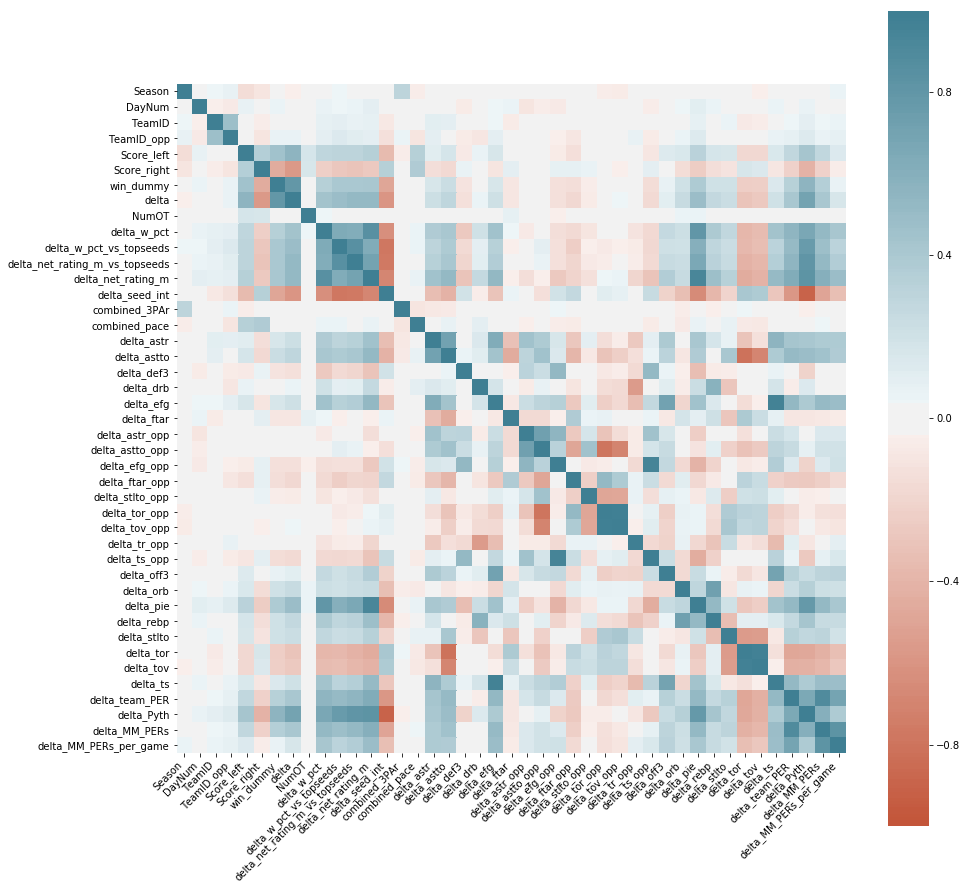

In [345]:
corr = df_clean.corr()

fig, ax = plt.subplots(figsize=(15,15)) 

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [346]:
# Correlations between variables and winning
df_clean.corr()['win_dummy'].reindex(df_clean.corr()['win_dummy'].abs().sort_values(ascending=False).index)

win_dummy                         1.000000
delta                             0.796271
delta_Pyth                        0.561794
delta_seed_int                   -0.490665
Score_right                      -0.458400
Score_left                        0.445668
delta_net_rating_m                0.418688
delta_net_rating_m_vs_topseeds    0.405464
delta_w_pct_vs_topseeds           0.403057
delta_pie                         0.383182
delta_MM_PERs                     0.356066
delta_w_pct                       0.346901
delta_team_PER                    0.328796
delta_tor                        -0.246414
delta_astto                       0.237240
delta_tov                        -0.229011
delta_rebp                        0.206810
delta_orb                         0.202514
delta_stlto                       0.199300
delta_efg                         0.163826
delta_astr                        0.160531
delta_ts_opp                     -0.156028
delta_ts                          0.148005
delta_ftar_

Variable could not be plotted: win_dummy
Variable could not be plotted: NumOT


/dsw/snapshots/snapshot_dsw_default_jupyter/python3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


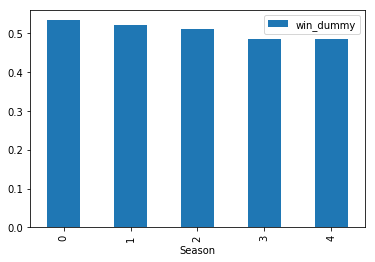

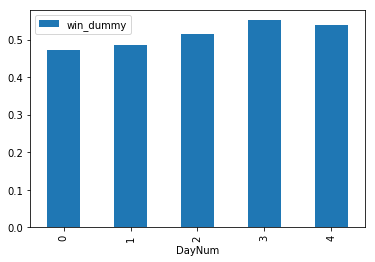

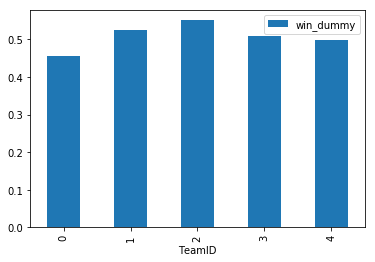

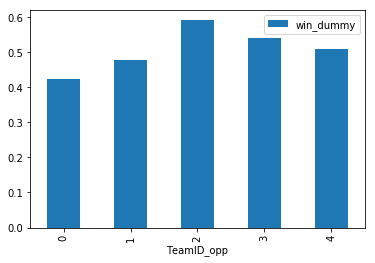

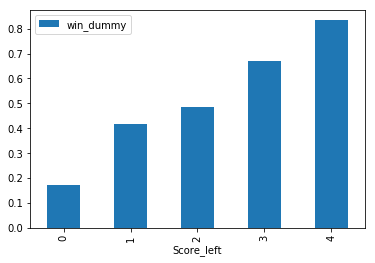

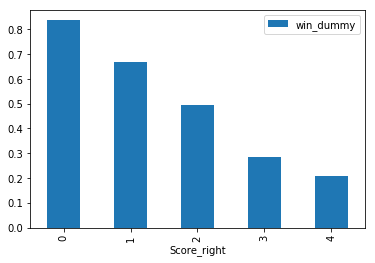

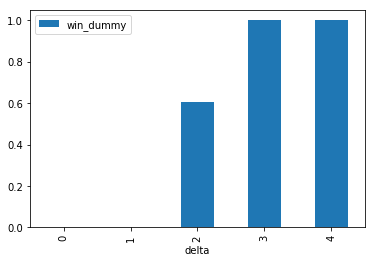

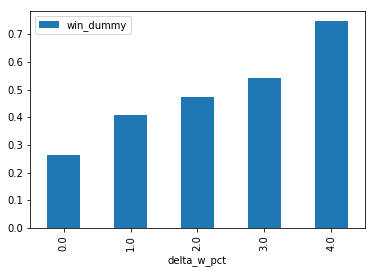

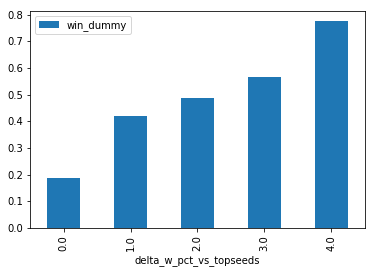

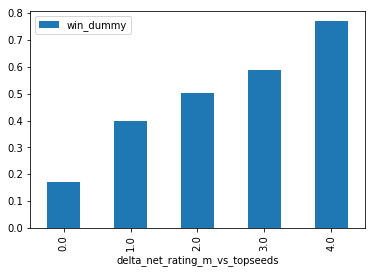

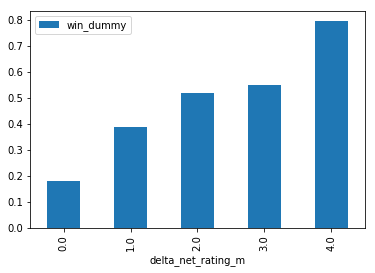

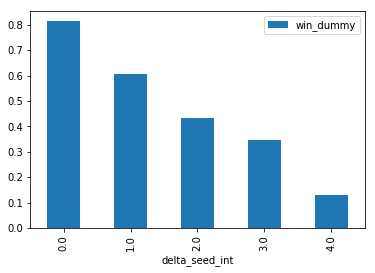

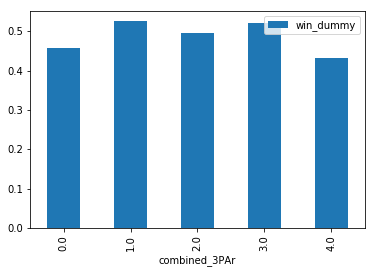

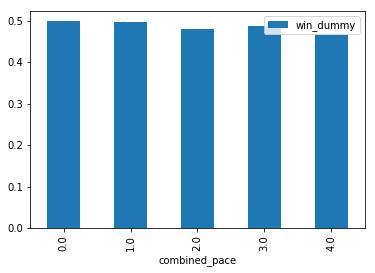

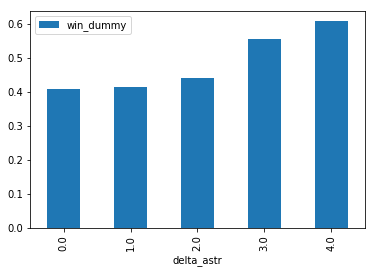

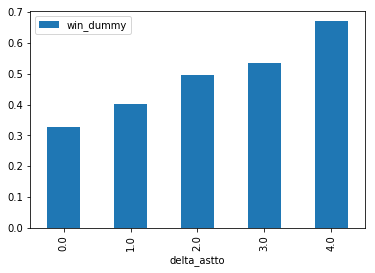

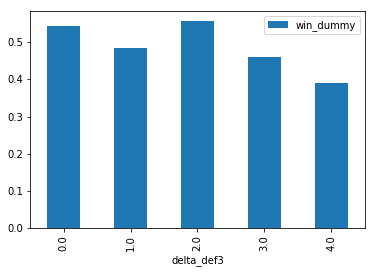

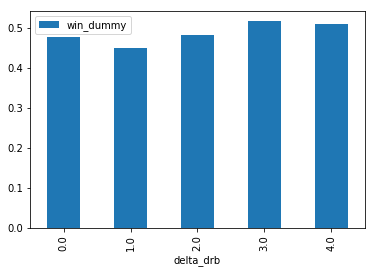

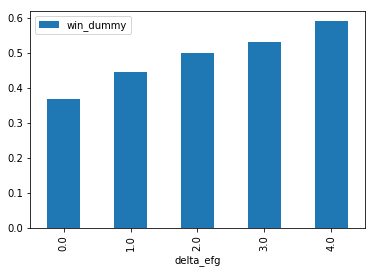

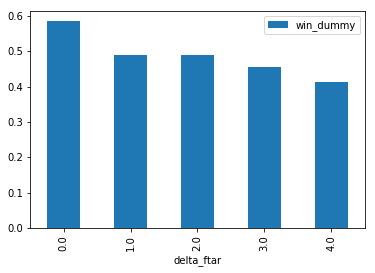

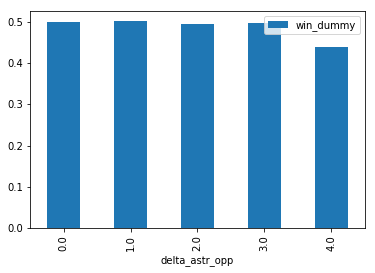

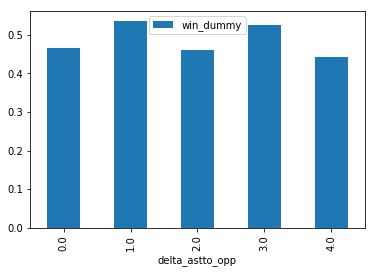

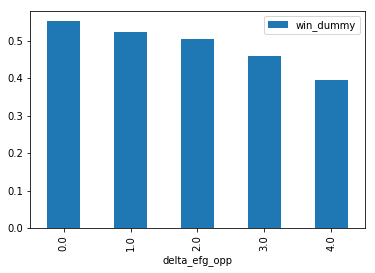

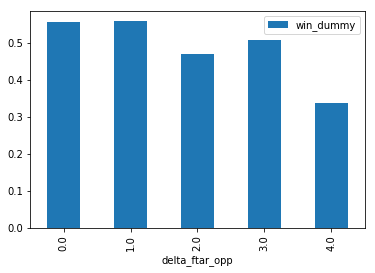

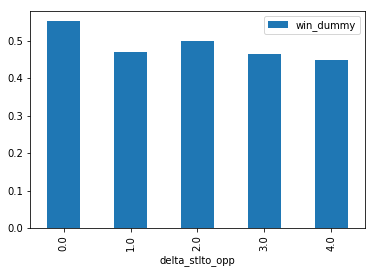

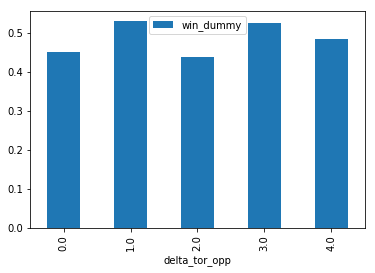

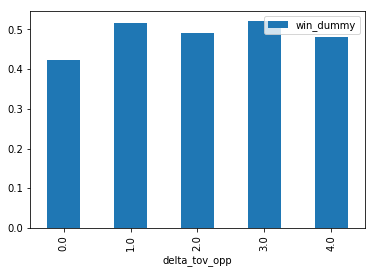

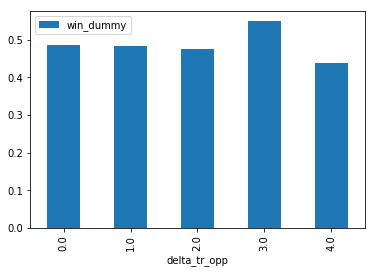

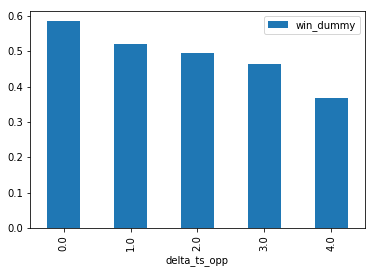

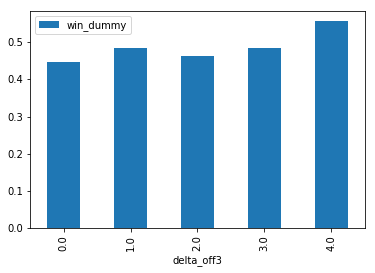

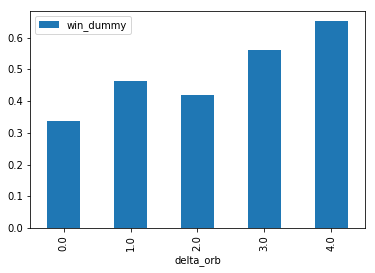

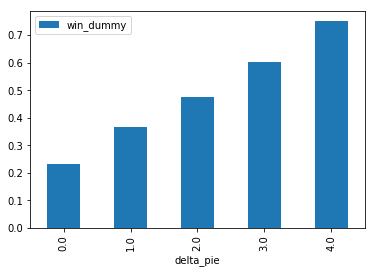

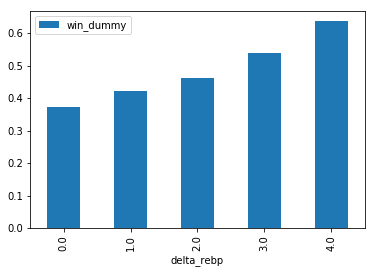

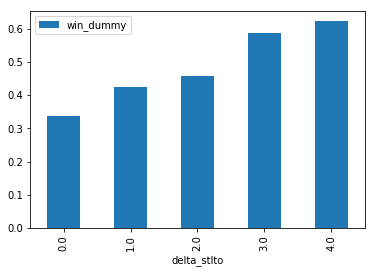

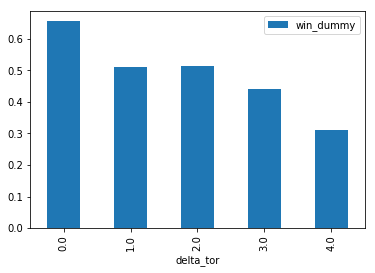

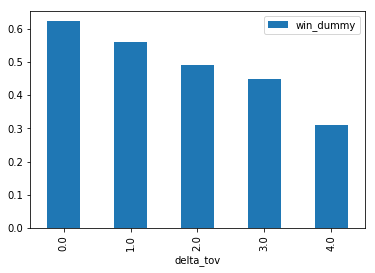

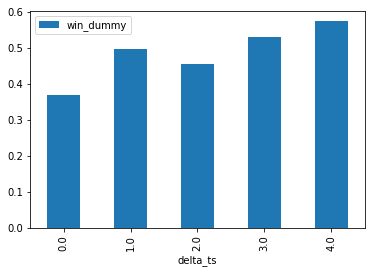

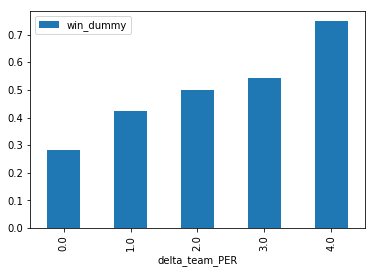

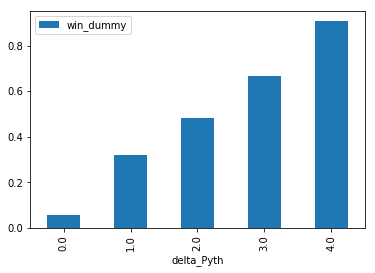

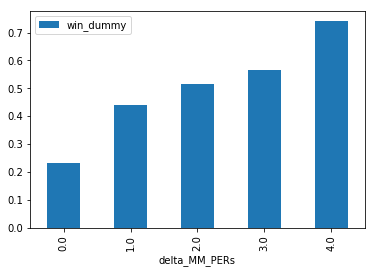

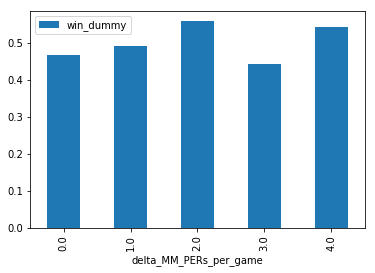

In [347]:
for col in df_clean.columns:
    
    try:
        temp_df = pd.concat([df_clean.win_dummy, pd.qcut(df_clean[col], 5, labels=False)], axis=1)
        temp_df = temp_df.groupby([col]).mean()

        temp_df.plot.bar()
    except:
        print("Variable could not be plotted: "+col)

In [349]:
season_player_stats_df.head()

,Season,PlayerID,TeamID,2PA,2PM,3PA,3PM,AST,BLK,DRB,FTA,FTM,G,ORB,PF,STL,TOV,PTS,team_AST,team_FG,PER,PlayerName,Played_in_MM,games_played_season,PER_per_game
0,2010,600001,1102,16,12,8,2,7,0,11,9,4,16,6,21,7,6,34,356,580,27.095400,BOHANNON_ZACH,0,16,1.693463
1,2010,600002,1102,0,0,0,0,0,0,0,0,0,4,1,2,0,0,0,356,580,0.162835,BRAKEVILLE_ADAM,0,4,0.040709
2,2010,600003,1102,43,20,24,1,11,9,41,39,25,23,13,30,4,22,68,356,580,28.517423,BROEKHUIS_TAYLOR,0,23,1.239888
3,2010,600004,1102,39,23,24,10,6,6,15,19,15,22,10,34,6,11,91,356,580,59.983442,BROOKS_DEREK,0,22,2.726520
4,2010,600005,1102,3,1,1,0,1,0,3,3,1,5,1,1,0,0,3,356,580,1.679780,EL-AMIN_SAJ,0,5,0.335956


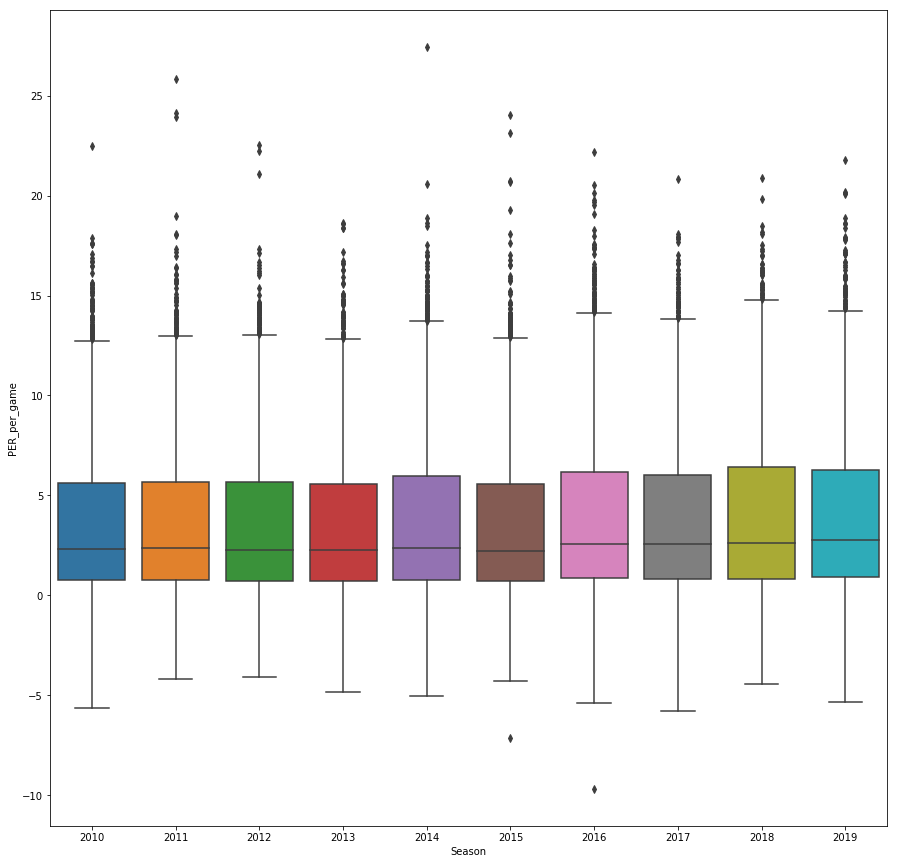

In [350]:
fig, ax = plt.subplots(figsize=(15,15)) 

ax = sns.boxplot(
    data=season_player_stats_df
    , x='Season'
    , y='PER_per_game'
)

In [352]:
season_player_stats_df.sort_values(by='PER', ascending=False).head(10)

,Season,PlayerID,TeamID,2PA,2PM,3PA,3PM,AST,BLK,DRB,FTA,FTM,G,ORB,PF,STL,TOV,PTS,team_AST,team_FG,PER,PlayerName,Played_in_MM,games_played_season,PER_per_game
42873,2018,648256,1112,405,258,33,12,56,65,279,181,138,34,113,85,19,68,690,517,980,636.526571,AYTON_DEANDRE,1,35,18.186473
18981,2013,619000,1325,238,120,342,127,406,12,155,236,161,33,18,116,131,199,782,1040,1500,632.220044,COOPER_DJ,1,34,18.594707
49179,2019,654612,1181,308,234,54,17,61,52,158,188,123,29,101,59,64,67,642,541,1037,631.306824,ZION_WILLIAMSON,0,29,21.769201
51643,2019,657082,1355,352,203,170,64,55,30,290,223,186,31,73,91,24,68,784,466,927,623.654556,MIKE_DAUM,0,31,20.117889
5823,2011,605829,1140,409,201,271,109,137,1,95,255,228,33,23,43,46,117,957,471,909,618.335525,FREDETTE_JIMMER,1,36,17.175987
12546,2012,612556,1246,270,182,18,3,32,157,239,152,112,34,102,68,47,32,485,450,929,614.914497,DAVIS_ANTHONY,1,40,15.372862
35206,2016,635255,1324,362,175,192,68,296,7,111,257,219,32,21,100,65,110,773,500,920,614.600510,FELDER_KAY,1,35,17.560015
6177,2011,606183,1163,443,209,189,64,150,6,138,259,214,35,49,51,68,77,824,459,910,608.803992,WALKER_KEMBA,1,39,15.610359
1753,2010,601756,1222,526,237,155,48,85,6,163,297,227,33,81,71,89,73,845,413,907,607.257884,COLEMAN_AUBREY,1,34,17.860526
49747,2019,655183,1220,371,210,247,106,94,6,120,195,167,33,10,62,29,88,905,450,930,606.558658,JUSTIN_WRIGHT-FOREMAN,0,33,18.380565


In [354]:
season_player_stats_df[season_player_stats_df.games_played_season >= 10]\
                .sort_values(by='PER_per_game', ascending=False).head(10)

,Season,PlayerID,TeamID,2PA,2PM,3PA,3PM,AST,BLK,DRB,FTA,FTM,G,ORB,PF,STL,TOV,PTS,team_AST,team_FG,PER,PlayerName,Played_in_MM,games_played_season,PER_per_game
49179,2019,654612,1181,308,234,54,17,61,52,158,188,123,29,101,59,64,67,642,541,1037,631.306824,ZION_WILLIAMSON,0,29,21.769201
48653,2019,654080,1144,254,142,357,124,85,9,119,263,227,29,24,61,43,72,883,405,741,585.188092,CHRIS_CLEMONS,0,29,20.178900
51643,2019,657082,1355,352,203,170,64,55,30,290,223,186,31,73,91,24,68,784,466,927,623.654556,MIKE_DAUM,0,31,20.117889
50778,2019,656216,1293,334,188,144,49,290,24,126,245,199,29,38,46,47,155,722,501,856,582.403053,JA_MORANT,0,29,20.082864
36231,2016,636281,1392,390,249,0,0,48,95,189,155,102,30,128,68,27,39,600,489,843,604.966626,WARNEY_JAMEEL,1,31,19.515052
48409,2019,653834,1125,204,137,209,89,77,18,266,128,109,30,59,66,44,64,650,588,950,566.776841,DYLAN_WINDLER,0,30,18.892561
21614,2014,621636,1145,259,132,230,97,166,1,140,235,210,31,17,34,50,90,765,396,829,603.880523,BARON_BILLY,1,32,18.871266
49971,2019,655408,1236,266,166,129,45,163,30,191,171,126,30,65,68,63,90,593,450,870,559.078396,JOHN_KONCHAR,0,30,18.635947
18981,2013,619000,1325,238,120,342,127,406,12,155,236,161,33,18,116,131,199,782,1040,1500,632.220044,COOPER_DJ,1,34,18.594707
49491,2019,654926,1202,286,179,23,8,121,34,194,151,116,29,80,67,74,66,498,451,805,538.641903,MATT_RAFFERTY,0,29,18.573859


# Train model

In [393]:
X_df = df_tourn_cl_with_MM_PERs.copy()

# Limit to >=2010 seasons when play by play data began

X_df = df_tourn_cl_with_MM_PERs[df_tourn_cl_with_MM_PERs.Season >= 2010]
X_df.head()

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth,delta_MM_PERs,delta_MM_PERs_per_game
1584,2010,134,1115,1457,61,44,1,17,0,-0.035417,0.000000,22.035150,-2.183810,0.0,0.255469,68.132266,1.407938,-0.174085,0.027205,0.041107,0.033585,0.143081,0.263536,-0.099908,0.020183,0.175047,-0.048287,2.435623,0.017533,-1.918750,0.034336,0.057647,0.017937,0.018596,3.968697,-0.327201,4.957981,0.046444,0.044507,57.443994,-0.81,-41.495246,-0.848219
1585,2010,136,1124,1358,68,59,1,9,0,0.024194,0.615385,17.255554,3.512922,-11.0,0.362848,69.456581,-4.548869,-0.563552,0.005137,-0.017937,0.001388,-0.030145,-3.338227,-0.095792,-0.022312,-0.073867,0.022256,-0.959433,-0.012936,0.782258,-0.027611,0.013402,0.039002,0.078384,2.111195,-0.136653,1.783139,0.011241,0.004316,330.166034,17.53,386.294248,2.447852
1586,2010,136,1139,1431,77,59,1,18,0,0.062500,0.071429,1.003042,0.865965,-7.0,0.353642,67.738477,-0.507500,-0.071420,0.016387,0.027365,-0.003863,0.073951,0.341006,0.056583,0.020816,-0.055598,0.027654,-0.846278,-0.004687,-6.375000,0.024054,0.010304,0.026191,-0.008069,2.713097,-0.068235,0.497323,0.002269,0.016335,-230.846556,5.92,-201.961190,-14.775548
1587,2010,136,1140,1196,99,92,1,7,2,0.212121,0.171717,3.370973,16.474402,-3.0,0.325753,68.875758,1.331363,0.271585,0.003943,0.064747,0.056231,0.043755,-1.265667,-0.110256,-0.021662,0.082023,-0.038923,0.839301,0.001132,-2.363636,-0.004824,0.115463,-0.052500,0.102002,1.621750,0.172131,-1.254702,-0.013172,0.065575,316.202002,8.04,321.510202,12.879013
1588,2010,136,1242,1250,90,74,1,16,0,0.253676,0.866667,33.035098,16.019795,-15.0,0.299500,70.210398,1.156818,0.211470,-0.005717,-0.026307,0.033472,-0.008658,-1.499307,-0.020010,-0.030184,0.000133,0.092225,0.019923,-0.003157,-0.636029,-0.028883,0.012616,0.084037,0.128336,3.200058,0.206718,-0.632449,-0.004443,0.025684,694.875528,32.82,685.082842,12.997707


In [394]:
drop_cols = ['Season'
             , 'DayNum'
             , 'TeamID'
             , 'TeamID_opp'
             , 'Score_left'
             , 'Score_right'
             , 'delta'
             , 'NumOT']

X_df = X_df.drop(drop_cols, axis=1)
X_df.head()

,win_dummy,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth,delta_MM_PERs,delta_MM_PERs_per_game
1584,1,-0.035417,0.000000,22.035150,-2.183810,0.0,0.255469,68.132266,1.407938,-0.174085,0.027205,0.041107,0.033585,0.143081,0.263536,-0.099908,0.020183,0.175047,-0.048287,2.435623,0.017533,-1.918750,0.034336,0.057647,0.017937,0.018596,3.968697,-0.327201,4.957981,0.046444,0.044507,57.443994,-0.81,-41.495246,-0.848219
1585,1,0.024194,0.615385,17.255554,3.512922,-11.0,0.362848,69.456581,-4.548869,-0.563552,0.005137,-0.017937,0.001388,-0.030145,-3.338227,-0.095792,-0.022312,-0.073867,0.022256,-0.959433,-0.012936,0.782258,-0.027611,0.013402,0.039002,0.078384,2.111195,-0.136653,1.783139,0.011241,0.004316,330.166034,17.53,386.294248,2.447852
1586,1,0.062500,0.071429,1.003042,0.865965,-7.0,0.353642,67.738477,-0.507500,-0.071420,0.016387,0.027365,-0.003863,0.073951,0.341006,0.056583,0.020816,-0.055598,0.027654,-0.846278,-0.004687,-6.375000,0.024054,0.010304,0.026191,-0.008069,2.713097,-0.068235,0.497323,0.002269,0.016335,-230.846556,5.92,-201.961190,-14.775548
1587,1,0.212121,0.171717,3.370973,16.474402,-3.0,0.325753,68.875758,1.331363,0.271585,0.003943,0.064747,0.056231,0.043755,-1.265667,-0.110256,-0.021662,0.082023,-0.038923,0.839301,0.001132,-2.363636,-0.004824,0.115463,-0.052500,0.102002,1.621750,0.172131,-1.254702,-0.013172,0.065575,316.202002,8.04,321.510202,12.879013
1588,1,0.253676,0.866667,33.035098,16.019795,-15.0,0.299500,70.210398,1.156818,0.211470,-0.005717,-0.026307,0.033472,-0.008658,-1.499307,-0.020010,-0.030184,0.000133,0.092225,0.019923,-0.003157,-0.636029,-0.028883,0.012616,0.084037,0.128336,3.200058,0.206718,-0.632449,-0.004443,0.025684,694.875528,32.82,685.082842,12.997707


In [395]:
y = X_df.pop('win_dummy')

In [396]:
scaler = StandardScaler()
scaler.fit(X_df) 
X_scaled = pd.DataFrame(scaler.transform(X_df), columns = X_df.columns)

In [397]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=23)

In [398]:
logreg = LogisticRegression(solver='liblinear')
params = {'C': np.logspace(start=-3, stop=8, num=12)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True, cv=5)

In [399]:
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4242, with best C: 1.0


/dsw/snapshots/snapshot_dsw_default_jupyter/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [400]:
preds = clf.predict_proba(X_test)

log_loss(y_test, preds)

0.49735020949342906

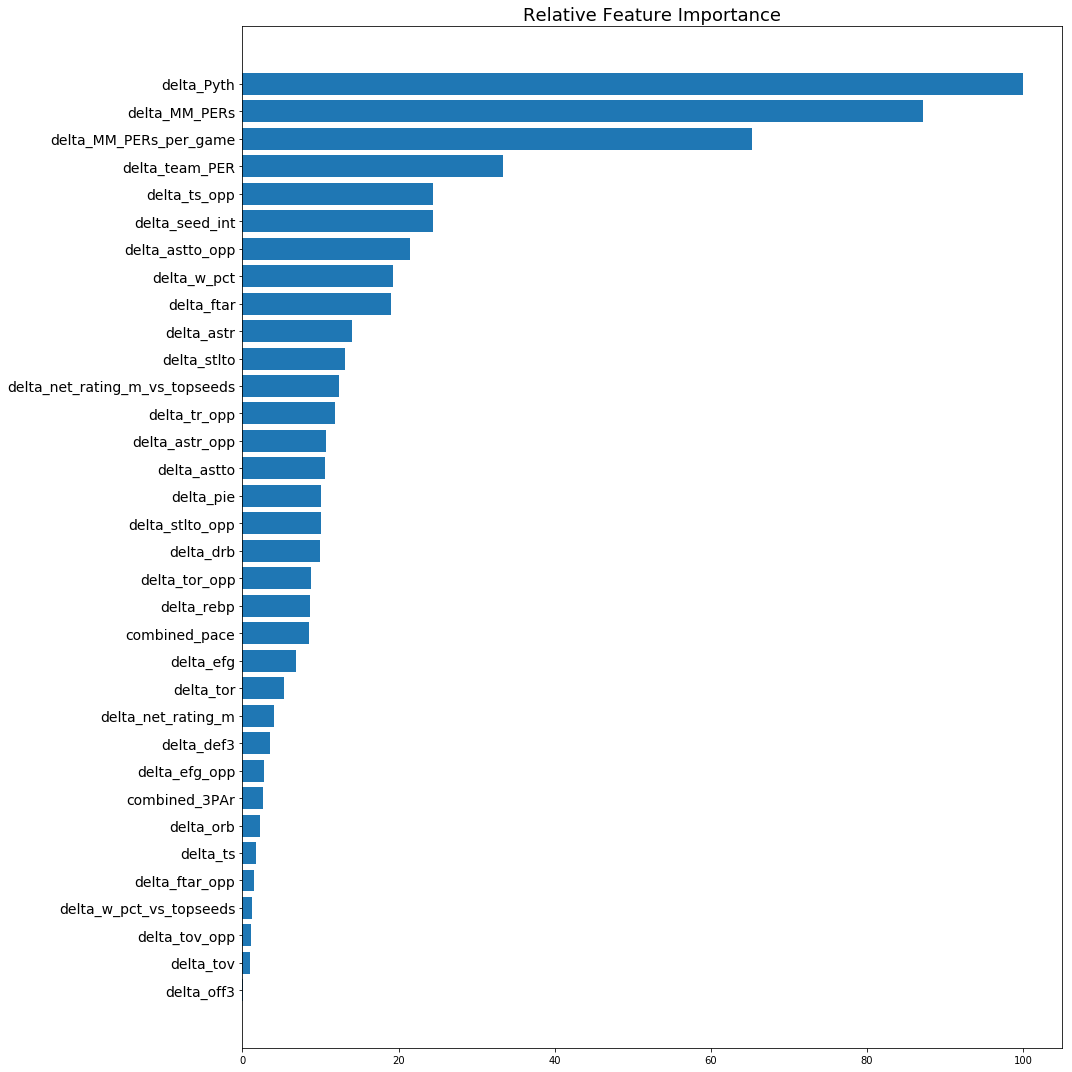

In [401]:
feature_importance = abs(clf.best_estimator_.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(15,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_df.columns)[sorted_idx], fontsize=14)
featax.set_title('Relative Feature Importance', fontsize=18)

plt.tight_layout()   
plt.show()

In [402]:
clf.fit(X_scaled, y)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4376, with best C: 1.0


# Prepare 2019 tournament data

In [433]:
df_sample_sub = pd.read_csv(path_datasets + 'SampleSubmissionStage2.csv')
df_sample_sub['Season'] = df_sample_sub.ID.str.slice(0, 4).apply(int)
df_sample_sub['TeamID'] = df_sample_sub.ID.str.slice(5, 9).apply(int)
df_sample_sub['TeamID_opp'] = df_sample_sub.ID.str.slice(10, 14).apply(int)
df_sample_sub.drop(columns=['ID', 'Pred'], inplace=True)
df_sample_sub.head()

,Season,TeamID,TeamID_opp
0,2019,1101,1113
1,2019,1101,1120
2,2019,1101,1124
3,2019,1101,1125
4,2019,1101,1133


In [434]:
df_pred = df_sample_sub.copy()

df_pred = pd.merge(left=df_pred, 
                        right=df_teams_gr_left, 
                        how='left', on=['Season', 'TeamID'])

df_pred = pd.merge(left=df_pred, 
                        right=df_teams_gr_right, 
                        how='left', on=['Season', 'TeamID_opp'])

for team_stat_col in team_stats_cols:
    df_pred['delta_'+team_stat_col] = df_pred[team_stat_col+'_left']-df_pred[team_stat_col+'_right']
    
# Adding a couple of combined team stats
df_pred['combined_3PAr'] = (df_pred['3PAr_left']+df_pred['3PAr_right'])/2
df_pred['combined_pace'] = (df_pred['pace_m_left']+df_pred['pace_m_right'])/2

df_pred = df_pred[['Season'
                   , 'TeamID'
                   , 'TeamID_opp'
                   , 'delta_w_pct'
                   , 'delta_w_pct_vs_topseeds'
                   , 'delta_net_rating_m_vs_topseeds'
                   , 'delta_net_rating_m'
                   , 'delta_seed_int'
                   , 'combined_3PAr'
                   , 'combined_pace'
                   , 'delta_astr'
                   , 'delta_astto'
                   , 'delta_def3'
                   , 'delta_drb'
                   , 'delta_efg'
                   , 'delta_ftar'
                   , 'delta_astr_opp'
                   , 'delta_astto_opp'
                   , 'delta_efg_opp'
                   , 'delta_ftar_opp'
                   , 'delta_stlto_opp'
                   , 'delta_tor_opp'
                   , 'delta_tov_opp'
                   , 'delta_tr_opp'
                   , 'delta_ts_opp'
                   , 'delta_off3'
                   , 'delta_orb'
                   , 'delta_pie'
                   , 'delta_rebp'
                   , 'delta_stlto'
                   , 'delta_tor'
                   , 'delta_tov'
                   , 'delta_ts'
                   , 'delta_team_PER'
                   , 'delta_Pyth']].copy()

df_pred.tail()

,Season,TeamID,TeamID_opp,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth
2273,2019,1449,1459,-0.101961,0.125000,8.533873,-10.924795,2.0,0.418008,68.079988,-2.313080,-0.464079,-0.002033,-0.100897,-0.052992,0.073425,0.941569,-0.074285,-0.022785,0.033386,-0.001586,2.623115,0.027651,3.131373,-0.018820,-0.071775,-0.034137,-0.027840,-6.341702,0.124444,3.201930,0.026860,-0.042871,-84.202540,-7.34
2274,2019,1449,1463,0.014706,-0.208333,-1.304166,-2.095839,-5.0,0.372710,70.502101,-3.829711,-0.504023,0.022602,-0.102646,-0.035856,0.049869,0.654060,-0.371551,0.007868,0.050831,-0.215332,5.793041,0.059072,-0.699580,0.004853,-0.026342,0.029756,-0.009214,-5.205934,0.238056,1.841661,0.011098,-0.032777,69.833628,4.78
2275,2019,1458,1459,-0.169697,0.466667,22.951185,-7.736518,-2.0,0.388184,67.429470,-0.996096,0.101102,-0.019072,-0.019617,-0.062163,-0.006162,-0.885868,0.198779,-0.041201,-0.077257,0.094290,-2.280701,-0.021282,4.321212,-0.056440,-0.054484,-0.081391,-0.006537,-4.397334,0.029574,-1.051256,-0.012142,-0.063656,-172.157960,2.97
2276,2019,1458,1463,-0.053030,0.133333,13.113147,1.092438,-9.0,0.342886,69.851583,-2.512727,0.061158,0.005563,-0.021366,-0.045026,-0.029718,-1.173376,-0.098488,-0.010548,-0.059812,-0.119455,0.889225,0.010139,0.490260,-0.032767,-0.009051,-0.017498,0.012088,-3.261566,0.143186,-2.411525,-0.027903,-0.053562,-18.121793,15.09
2277,2019,1459,1463,0.116667,-0.333333,-9.838039,8.828956,-7.0,0.390744,71.178780,-1.516631,-0.039944,0.024635,-0.001750,0.017136,-0.023556,-0.287508,-0.297266,0.030653,0.017445,-0.213745,3.169926,0.031422,-3.830952,0.023673,0.045432,0.063893,0.018625,1.135768,0.113612,-1.360269,-0.015762,0.010094,154.036167,12.12


In [435]:
df_pred = pd.merge(df_pred
                    , team_PERs_in_MM.rename(columns={'PER_in_MM': 'PER_in_MM_left'
                                                     ,'PER_per_game_in_MM': 'PER_per_game_in_MM_left'})
                    , how='left', on=['Season', 'TeamID'])

df_pred = pd.merge(df_pred
                    , team_PERs_in_MM.rename(columns={'TeamID': 'TeamID_opp'
                                                      ,'PER_in_MM': 'PER_in_MM_right'
                                                      ,'PER_per_game_in_MM': 'PER_per_game_in_MM_right'})
                    , how='left', on=['Season', 'TeamID_opp'])

In [436]:
df_pred['delta_MM_PERs'] = df_pred['PER_in_MM_left']\
                                             -df_pred['PER_in_MM_right']

df_pred['delta_MM_PERs_per_game'] = df_pred['PER_per_game_in_MM_left']\
                                             -df_pred['PER_per_game_in_MM_right']

df_pred.drop(columns=['PER_in_MM_left'
                                       , 'PER_in_MM_right'
                                       , 'PER_per_game_in_MM_left'
                                       , 'PER_per_game_in_MM_right'], inplace=True)

df_pred.head()

,Season,TeamID,TeamID_opp,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth,delta_MM_PERs,delta_MM_PERs_per_game
0,2019,1101,1113,0.105603,-0.625000,-46.407365,4.197052,4.0,0.351103,70.205805,2.368471,0.390469,-0.003543,-0.008955,0.012205,-0.089934,0.071713,-0.107852,0.026810,-0.025319,-0.088085,3.156047,0.033970,-3.877155,0.023969,0.043896,-0.050080,0.024112,-3.461017,0.240307,-0.930881,-0.003408,0.011695,-246.180992,-9.12,0.0,0.0
1,2019,1101,1120,0.057809,-0.500000,-45.639556,-2.257469,10.0,0.421456,68.241398,1.324236,0.115488,-0.030007,0.050806,-0.017923,0.028202,-0.014637,0.112946,-0.025292,0.050663,0.035408,-1.882656,-0.021718,-2.130832,-0.019103,0.010915,-0.044790,-0.003338,0.653613,-0.171694,0.098734,0.001552,-0.012095,-575.704255,-21.24,0.0,0.0
2,2019,1101,1124,0.199353,-0.500000,-45.687125,3.910842,6.0,0.373421,67.011860,1.464431,0.295332,-0.010529,0.010894,0.013981,0.013872,-0.646113,-0.160845,0.017128,0.058385,-0.062831,2.615773,0.023686,-1.783405,0.026735,0.051622,-0.104458,0.029555,-5.103094,0.260137,-1.454891,-0.013419,0.021367,-149.052059,-13.20,0.0,0.0
3,2019,1101,1125,-0.040230,-0.333333,-39.386808,-5.567171,4.0,0.391439,71.020884,-2.813206,-0.489780,-0.010680,-0.033916,-0.058043,0.058582,-0.257917,-0.284631,0.001669,0.117186,-0.173836,5.180460,0.048567,-2.956322,0.015873,0.017703,0.019963,-0.034624,-2.801065,0.097098,1.586669,0.010098,-0.045199,-554.852101,-10.98,0.0,0.0
4,2019,1101,1133,0.217346,0.000000,-45.572255,9.004066,0.0,0.347720,66.634463,2.391081,0.394128,-0.003688,-0.007369,0.027274,-0.021090,-0.220933,-0.151072,0.023629,0.068858,-0.077537,3.245866,0.030762,-0.901776,0.033330,0.025299,0.005955,0.057922,-1.098888,0.300974,-1.622966,-0.012215,0.027451,43.533702,2.45,0.0,0.0


In [437]:
drop_cols = ['Season'
             , 'TeamID'
             , 'TeamID_opp']

df_pred = df_pred.drop(drop_cols, axis=1)
df_pred.head()

,delta_w_pct,delta_w_pct_vs_topseeds,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int,combined_3PAr,combined_pace,delta_astr,delta_astto,delta_def3,delta_drb,delta_efg,delta_ftar,delta_astr_opp,delta_astto_opp,delta_efg_opp,delta_ftar_opp,delta_stlto_opp,delta_tor_opp,delta_tov_opp,delta_tr_opp,delta_ts_opp,delta_off3,delta_orb,delta_pie,delta_rebp,delta_stlto,delta_tor,delta_tov,delta_ts,delta_team_PER,delta_Pyth,delta_MM_PERs,delta_MM_PERs_per_game
0,0.105603,-0.625000,-46.407365,4.197052,4.0,0.351103,70.205805,2.368471,0.390469,-0.003543,-0.008955,0.012205,-0.089934,0.071713,-0.107852,0.026810,-0.025319,-0.088085,3.156047,0.033970,-3.877155,0.023969,0.043896,-0.050080,0.024112,-3.461017,0.240307,-0.930881,-0.003408,0.011695,-246.180992,-9.12,0.0,0.0
1,0.057809,-0.500000,-45.639556,-2.257469,10.0,0.421456,68.241398,1.324236,0.115488,-0.030007,0.050806,-0.017923,0.028202,-0.014637,0.112946,-0.025292,0.050663,0.035408,-1.882656,-0.021718,-2.130832,-0.019103,0.010915,-0.044790,-0.003338,0.653613,-0.171694,0.098734,0.001552,-0.012095,-575.704255,-21.24,0.0,0.0
2,0.199353,-0.500000,-45.687125,3.910842,6.0,0.373421,67.011860,1.464431,0.295332,-0.010529,0.010894,0.013981,0.013872,-0.646113,-0.160845,0.017128,0.058385,-0.062831,2.615773,0.023686,-1.783405,0.026735,0.051622,-0.104458,0.029555,-5.103094,0.260137,-1.454891,-0.013419,0.021367,-149.052059,-13.20,0.0,0.0
3,-0.040230,-0.333333,-39.386808,-5.567171,4.0,0.391439,71.020884,-2.813206,-0.489780,-0.010680,-0.033916,-0.058043,0.058582,-0.257917,-0.284631,0.001669,0.117186,-0.173836,5.180460,0.048567,-2.956322,0.015873,0.017703,0.019963,-0.034624,-2.801065,0.097098,1.586669,0.010098,-0.045199,-554.852101,-10.98,0.0,0.0
4,0.217346,0.000000,-45.572255,9.004066,0.0,0.347720,66.634463,2.391081,0.394128,-0.003688,-0.007369,0.027274,-0.021090,-0.220933,-0.151072,0.023629,0.068858,-0.077537,3.245866,0.030762,-0.901776,0.033330,0.025299,0.005955,0.057922,-1.098888,0.300974,-1.622966,-0.012215,0.027451,43.533702,2.45,0.0,0.0


# Predict 2019 tournament

In [438]:
scaler = StandardScaler()
scaler.fit(df_pred) 
X_scaled = pd.DataFrame(scaler.transform(df_pred), columns = df_pred.columns)

In [439]:
preds = clf.predict_proba(X_scaled)[:,1]

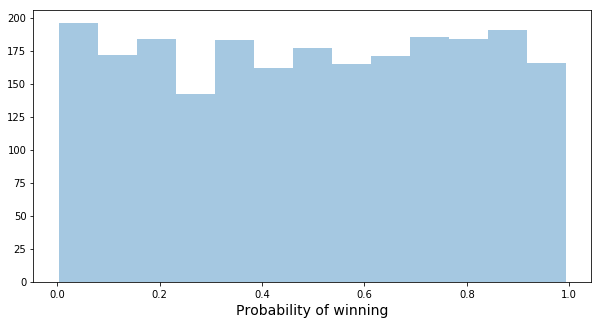

In [440]:
# Plot predicted probabilities to make sure nothing is weird

fig, ax = plt.subplots(figsize=(10,5))

ax = sns.distplot(preds, kde=False)
ax = ax.set_xlabel('Probability of winning', fontsize=14)

In [441]:
# Clip probabilities at 2.5% to avoid huge log losses due to upset

clipped_preds = np.clip(preds, 0.025, 0.975)
output_df = df_sample_sub.copy()
output_df['win_prob'] = clipped_preds

output_df.head()

,Season,TeamID,TeamID_opp,win_prob
0,2019,1101,1113,0.539985
1,2019,1101,1120,0.203567
2,2019,1101,1124,0.328620
3,2019,1101,1125,0.465235
4,2019,1101,1133,0.901635


In [447]:
# Check if Duke vs 16 seed (North Dakota State) makes sense, to make sure we selected the right column of pred array

df_teams[(df_teams.TeamName.str.contains('Duke'))|(df_teams.TeamName.str.contains('Dakota'))]

,TeamID,TeamName,FirstD1Season,LastD1Season
80,1181,Duke,1985,2019
194,1295,N Dakota St,2006,2019
214,1315,North Dakota,2009,2019
254,1355,S Dakota St,2006,2019
276,1377,South Dakota,2009,2019


In [449]:
cond1 = (output_df.TeamID == 1181)
cond2 = (output_df.TeamID_opp == 1295)

output_df[cond1&cond2]

,Season,TeamID,TeamID_opp,win_prob
592,2019,1181,1295,0.9474


In [450]:
output_df.to_csv('final_predictions.csv', index=False)